## 1. Setup & Data Loading

⚠️ **IMPORTANT**: This notebook evaluates models on the **HELD-OUT TEST SET** only!
- Models were trained on 80% of the data
- We evaluate on 20% the model has **NEVER seen**
- This gives us **honest, unbiased** performance metrics

In [2]:
!pip show matplotlib

Name: matplotlib
Version: 3.10.7
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: Unknown <matplotlib-users@python.org>
License: License agreement for matplotlib versions 1.3.0 and later

 1. This LICENSE AGREEMENT is between the Matplotlib Development Team
 ("MDT"), and the Individual or Organization ("Licensee") accessing and
 otherwise using matplotlib software in source or binary form and its
 associated documentation.

 2. Subject to the terms and conditions of this License Agreement, MDT
 hereby grants Licensee a nonexclusive, royalty-free, world-wide license
 to reproduce, analyze, test, perform and/or display publicly, prepare
 derivative works, distribute, and otherwise use matplotlib
 alone or in any derivative version, provided, however, that MDT's
 License Agreement and MDT's notice of copyright, i.e., "Copyright (c)
 2012- Matplotlib Development Team; All Rights Reserved" are retained in
 matplotlib

In [2]:
# Imports
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from backend.services.ml_service import MLService

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('pastel')

# Ensure interactive plots render correctly
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#FAFAFA'
plt.rcParams['font.size'] = 10

# Subtle pastel color palette
COLORS = {
    'xgboost': '#A8D8EA',      # Soft blue

    'lightgbm': '#B5EAD7',     # Soft mintprint("✓ Setup complete")

    'catboost': '#FFE5B4',     # Soft peach

    'decision_tree': '#FFDAC1', # Soft coralCLASS_COLORS = ['#A8D8EA', '#FFE5B4', '#B5EAD7']  # C, CL, D - soft pastels

    'ensemble': '#E2C2FF'}      # Soft lavender

In [3]:
# Load models and TEST DATA (held-out, never seen during training!)
ml_service = MLService(model_dir=str(project_root / "backend" / "models"))
ml_service.load_models()

# Load the held-out test set saved during training
test_data_path = project_root / "backend" / "models" / "test_data.pkl"
if not test_data_path.exists():
    raise FileNotFoundError(
        "❌ Test data not found! Please retrain the model with:\n"
        "   python -m scripts.train_model\n"
        "This will create a proper train/test split."
    )

test_data = joblib.load(test_data_path)
X_test = test_data['X_test']
y_test = test_data['y_test']

# Get class info
classes = np.array(ml_service.classes_)
n_classes = len(classes)

# Binarize for ROC/PR curves
y_bin = label_binarize(y_test, classes=range(n_classes))

print("=" * 60)
print("🔒 HONEST EVALUATION - Using HELD-OUT TEST SET")
print("=" * 60)
print(f"\n✓ Models loaded from: backend/models/")
print(f"✓ Test set size: {len(y_test)} samples (20% of data)")
print(f"✓ These samples were NEVER seen during training!")
print(f"\n✓ Classes: {list(classes)}")
print(f"\nTest Set Class Distribution:")
for i, cls in enumerate(classes):
    count = np.sum(y_test == i)
    print(f"  {cls}: {count} ({count/len(y_test)*100:.1f}%)")

Models loaded successfully
🔒 HONEST EVALUATION - Using HELD-OUT TEST SET

✓ Models loaded from: backend/models/
✓ Test set size: 1917 samples (20% of data)
✓ These samples were NEVER seen during training!

✓ Classes: [np.str_('C'), np.str_('CL'), np.str_('D')]

Test Set Class Distribution:
  C: 1061 (55.3%)
  CL: 121 (6.3%)
  D: 735 (38.3%)


In [4]:
# Generate predictions on HELD-OUT TEST SET (honest evaluation!)
base_models = ml_service.base_models

# Store predictions and probabilities for each model
model_predictions = {}
model_probabilities = {}
model_metrics = {}

print("🔍 Evaluating on HELD-OUT TEST SET (never seen during training)...\n")

for name, model in base_models.items():
    print(f"  {name}...", end=" ")
    
    # Predict on TEST SET (not training data!)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    model_predictions[name] = y_pred
    model_probabilities[name] = y_proba
    
    # Calculate metrics on TEST SET
    model_metrics[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    }
    print(f"Test Accuracy: {model_metrics[name]['accuracy']:.4f}")

# Generate ensemble predictions on TEST SET
print("\n  ensemble...", end=" ")
meta_features = np.hstack([model_probabilities[name] for name in base_models.keys()])

y_pred_ensemble = ml_service.meta_model.predict(meta_features)
y_proba_ensemble = ml_service.meta_model.predict_proba(meta_features)

model_predictions['ensemble'] = y_pred_ensemble
model_probabilities['ensemble'] = y_proba_ensemble
model_metrics['ensemble'] = {
    'accuracy': accuracy_score(y_test, y_pred_ensemble),
    'precision': precision_score(y_test, y_pred_ensemble, average='weighted'),
    'recall': recall_score(y_test, y_pred_ensemble, average='weighted'),
    'f1': f1_score(y_test, y_pred_ensemble, average='weighted'),
    'roc_auc': roc_auc_score(y_test, y_proba_ensemble, multi_class='ovr', average='weighted')
}
print(f"Test Accuracy: {model_metrics['ensemble']['accuracy']:.4f}")

print("\n" + "=" * 60)
print("✅ All metrics are on UNSEEN TEST DATA - These are HONEST!")
print("=" * 60)

🔍 Evaluating on HELD-OUT TEST SET (never seen during training)...

  xgboost... Test Accuracy: 0.9557
  lightgbm... Test Accuracy: 0.9624
  catboost... Test Accuracy: 0.8957
  decision_tree... Test Accuracy: 0.7387

  ensemble... Test Accuracy: 0.9656

✅ All metrics are on UNSEEN TEST DATA - These are HONEST!
Test Accuracy: 0.8957
  decision_tree... Test Accuracy: 0.7387

  ensemble... Test Accuracy: 0.9656

✅ All metrics are on UNSEEN TEST DATA - These are HONEST!


## 2. Per-Model Performance

### 2.1 ROC Curves (One-vs-Rest)

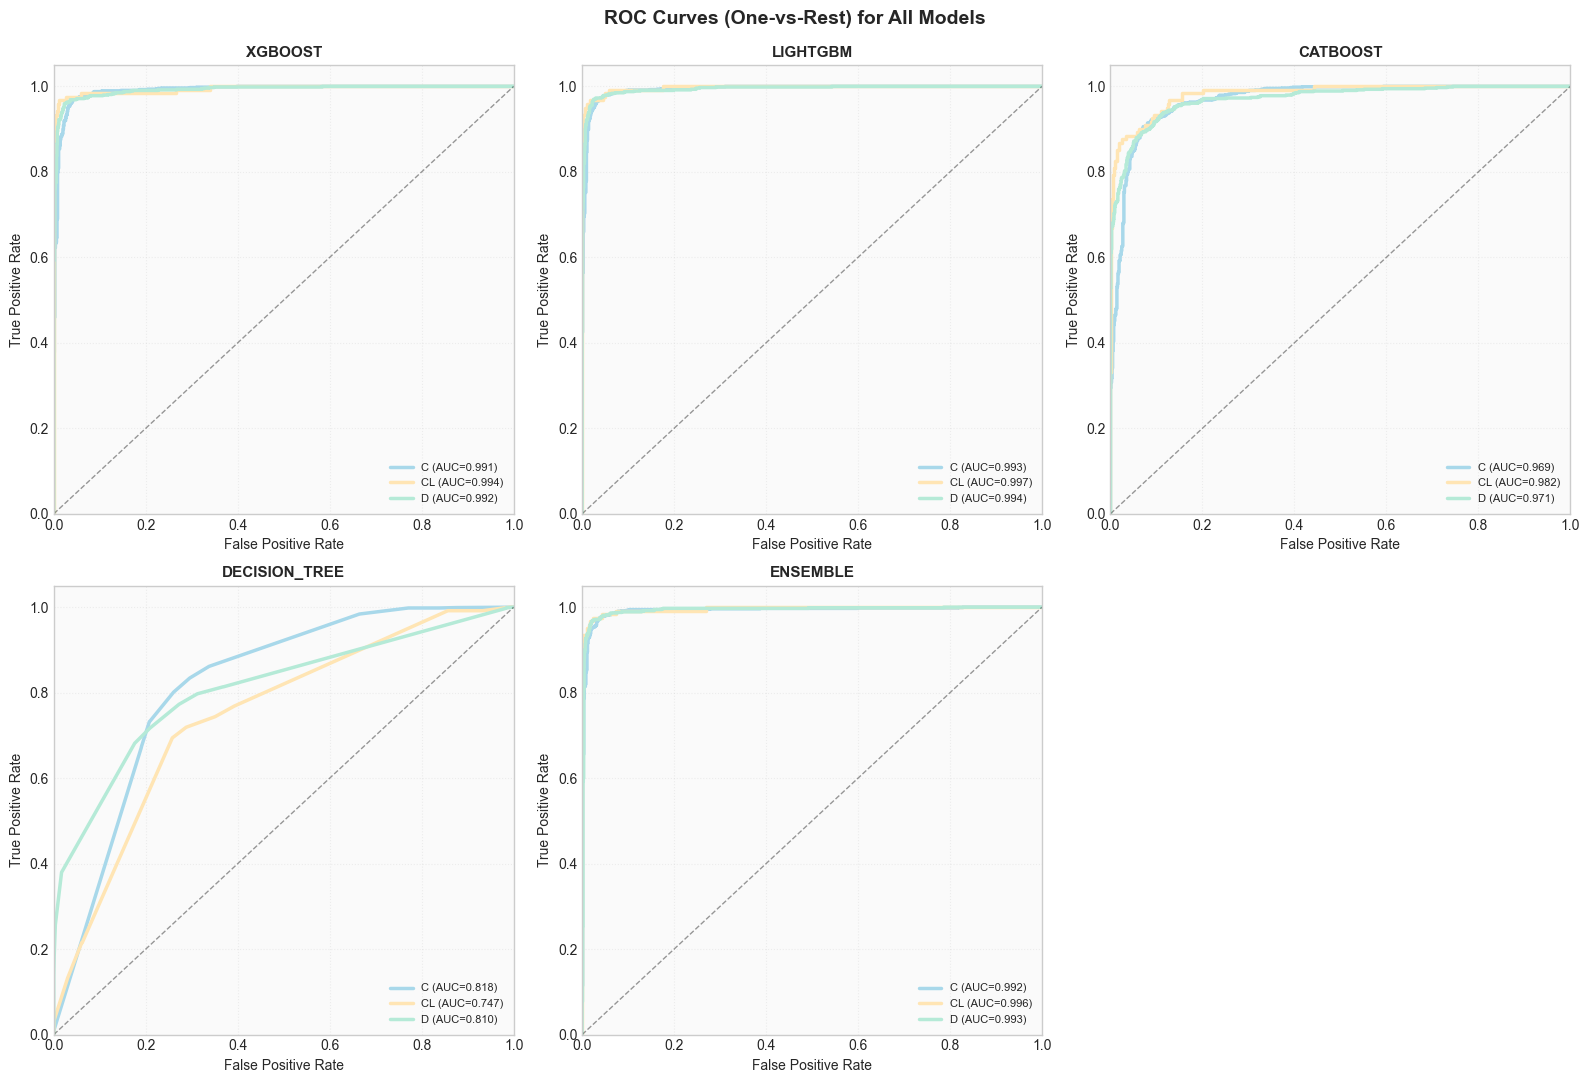

In [5]:
# ROC Curves for each model
fig, axes = plt.subplots(2, 3, figsize=(16, 11))
axes = axes.flatten()

# Subtle pastel colors for classes
roc_colors = ['#A8D8EA', '#FFE5B4', '#B5EAD7']  # Soft blue, peach, mint

for idx, (name, y_proba) in enumerate(model_probabilities.items()):
    ax = axes[idx]
    
    # Plot ROC for each class
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=roc_colors[i], lw=2.5,
                label=f'{cls} (AUC={roc_auc:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.4)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=10)
    ax.set_ylabel('True Positive Rate', fontsize=10)
    ax.set_title(f'{name.upper()}', fontsize=11, fontweight='bold')
    ax.legend(loc='lower right', fontsize=8, framealpha=0.95, edgecolor='none')
    ax.set_facecolor('#FAFAFA')
    ax.grid(alpha=0.3, linestyle=':')

# Hide empty subplot
axes[-1].axis('off')

plt.suptitle('ROC Curves (One-vs-Rest) for All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig(project_root / 'docs' / 'roc_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

### 2.2 Precision-Recall Curves

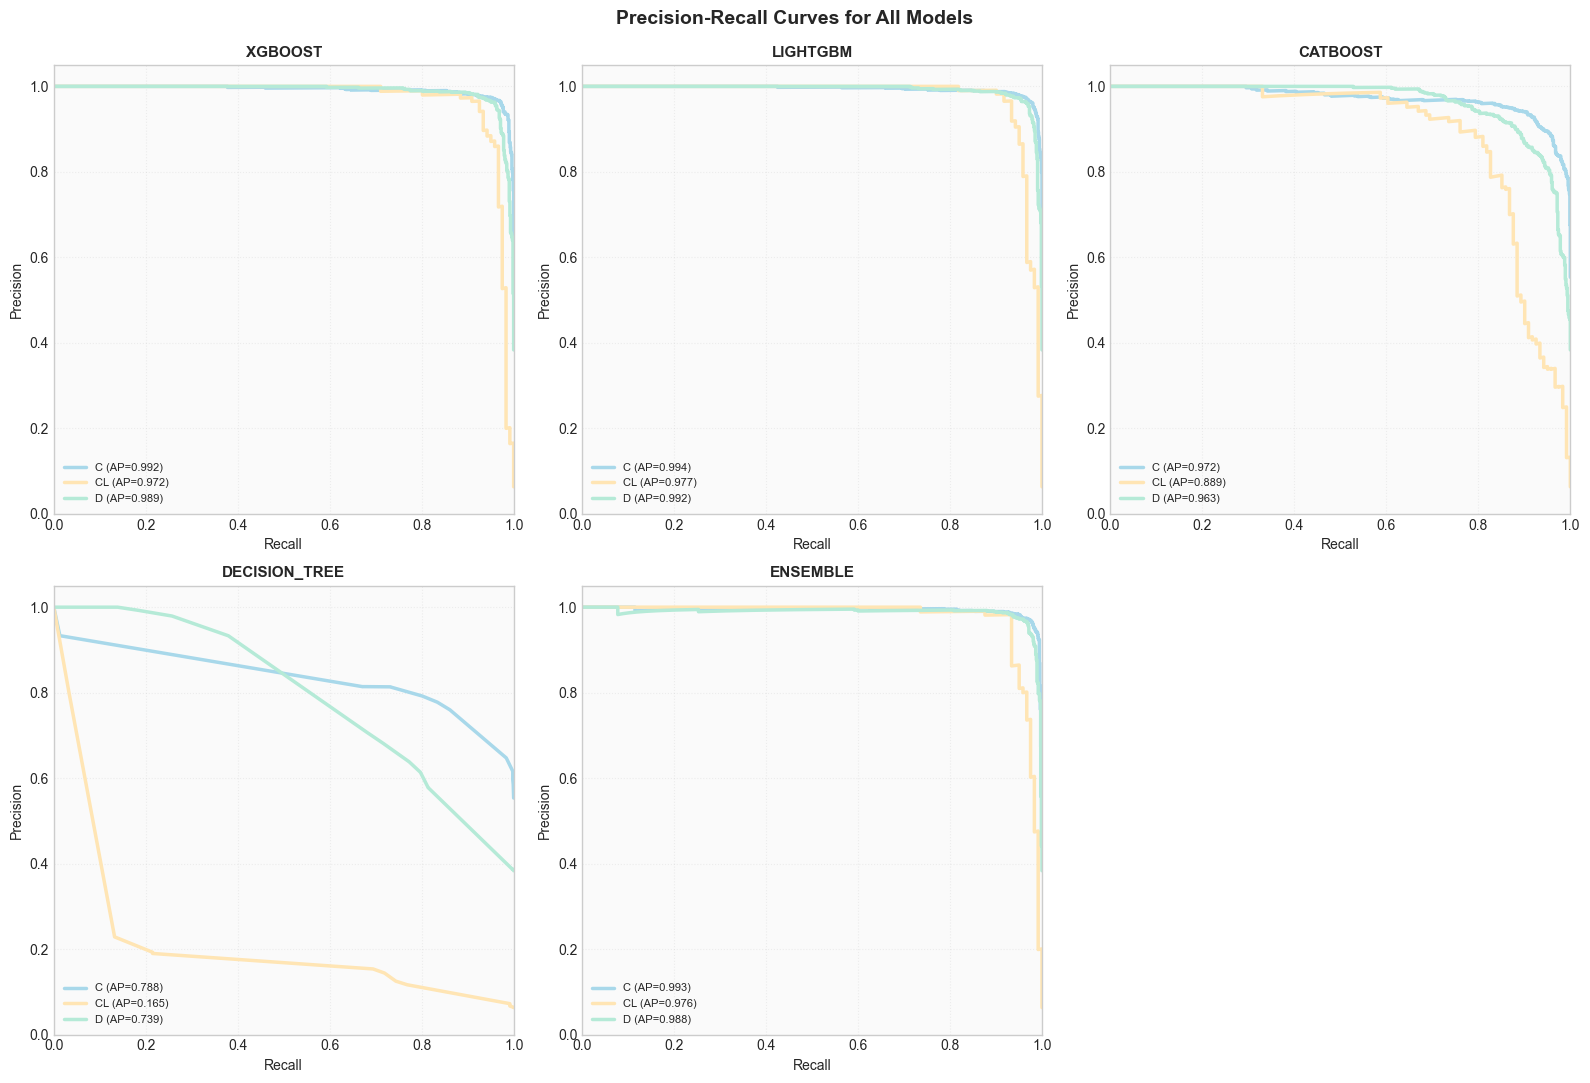

In [6]:
# Precision-Recall Curves
fig, axes = plt.subplots(2, 3, figsize=(16, 11))
axes = axes.flatten()

# Subtle pastel colors
pr_colors = ['#A8D8EA', '#FFE5B4', '#B5EAD7']  # Soft blue, peach, mint

for idx, (name, y_proba) in enumerate(model_probabilities.items()):
    ax = axes[idx]
    
    for i, cls in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_bin[:, i], y_proba[:, i])
        ap = average_precision_score(y_bin[:, i], y_proba[:, i])
        ax.plot(recall, precision, color=pr_colors[i], lw=2.5,
                label=f'{cls} (AP={ap:.3f})')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize=10)
    ax.set_ylabel('Precision', fontsize=10)
    ax.set_title(f'{name.upper()}', fontsize=11, fontweight='bold')
    ax.legend(loc='lower left', fontsize=8, framealpha=0.95, edgecolor='none')
    ax.set_facecolor('#FAFAFA')
    ax.grid(alpha=0.3, linestyle=':')

axes[-1].axis('off')

plt.suptitle('Precision-Recall Curves for All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig(project_root / 'docs' / 'pr_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

### 2.3 Confusion Matrices

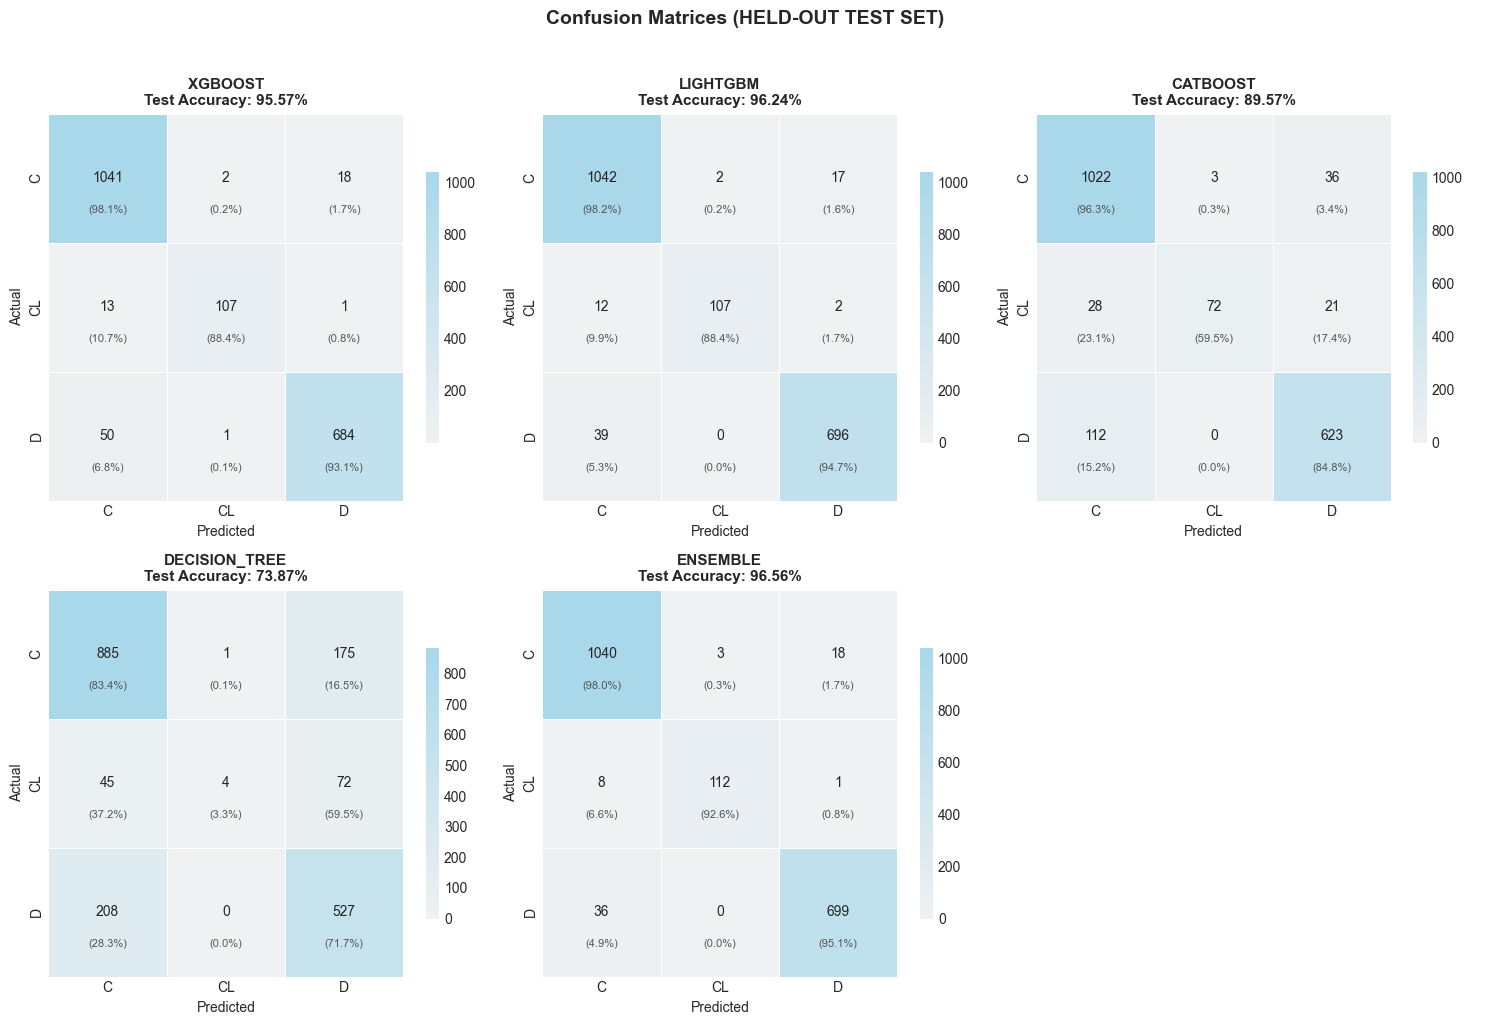

In [9]:
# Confusion Matrices for all models (on TEST SET)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Create a subtle colormap
cmap_subtle = sns.light_palette('#A8D8EA', as_cmap=True)

for idx, (name, y_pred) in enumerate(model_predictions.items()):
    ax = axes[idx]
    
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap_subtle, ax=ax,
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'shrink': 0.7}, linewidths=0.5, linecolor='white')
    
    # Add percentage annotations
    for i in range(len(classes)):
        for j in range(len(classes)):
            pct = cm_normalized[i, j] * 100
            ax.text(j + 0.5, i + 0.75, f'({pct:.1f}%)', 
                    ha='center', va='center', fontsize=8, color='#555555')
    
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('Actual', fontsize=10)
    ax.set_title(f'{name.upper()}\nTest Accuracy: {model_metrics[name]["accuracy"]:.2%}', 
                 fontsize=11, fontweight='bold')

axes[-1].axis('off')

plt.suptitle('Confusion Matrices (HELD-OUT TEST SET)', fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
# plt.close()

plt.savefig(project_root / 'docs' / 'confusion_matrices.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## 3. Model Comparison

### 3.1 Grouped Bar Chart - Metrics Comparison

In [10]:
# Grouped Bar Chart for Model Comparison
metrics_df = pd.DataFrame(model_metrics).T
metrics_df = metrics_df.round(4)

fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(metrics_df.index))
width = 0.15
multiplier = 0

# Subtle pastel colors
metric_colors = ['#A8D8EA', '#B5EAD7', '#FFE5B4', '#FFDAC1', '#E2C2FF']

for idx, (metric, values) in enumerate(metrics_df.items()):
    offset = width * multiplier
    bars = ax.bar(x + offset, values, width, label=metric.capitalize(), 
                  color=metric_colors[idx], edgecolor='white', linewidth=1)
    multiplier += 1

ax.set_ylabel('Score', fontsize=11)
ax.set_xlabel('Model', fontsize=11)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels([m.upper() for m in metrics_df.index], fontsize=10)

# Legend below chart to avoid overlap - with more space
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=5, fontsize=10, 
          framealpha=0.95, edgecolor='none', fancybox=True)

ax.set_ylim(0.7, 1.02)
ax.set_facecolor('#FAFAFA')
ax.grid(axis='y', alpha=0.3, linestyle=':')

plt.subplots_adjust(bottom=0.20)
plt.savefig(project_root / 'docs' / 'model_comparison_bar.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.savefig(project_root / 'docs' / 'model_comparison_bar.png', dpi=150, bbox_inches='tight')
plt.close()

print("\n📊 Model Metrics Summary:")

print(metrics_df.to_string())
print(metrics_df.to_string())


📊 Model Metrics Summary:
               accuracy  precision  recall      f1  roc_auc
xgboost          0.9557     0.9563  0.9557  0.9555   0.9915
lightgbm         0.9624     0.9628  0.9624  0.9623   0.9937
catboost         0.8957     0.8987  0.8957  0.8929   0.9702
decision_tree    0.7387     0.7420  0.7387  0.7173   0.8101
ensemble         0.9656     0.9657  0.9656  0.9655   0.9929
               accuracy  precision  recall      f1  roc_auc
xgboost          0.9557     0.9563  0.9557  0.9555   0.9915
lightgbm         0.9624     0.9628  0.9624  0.9623   0.9937
catboost         0.8957     0.8987  0.8957  0.8929   0.9702
decision_tree    0.7387     0.7420  0.7387  0.7173   0.8101
ensemble         0.9656     0.9657  0.9656  0.9655   0.9929


### 3.2 Radar/Spider Chart

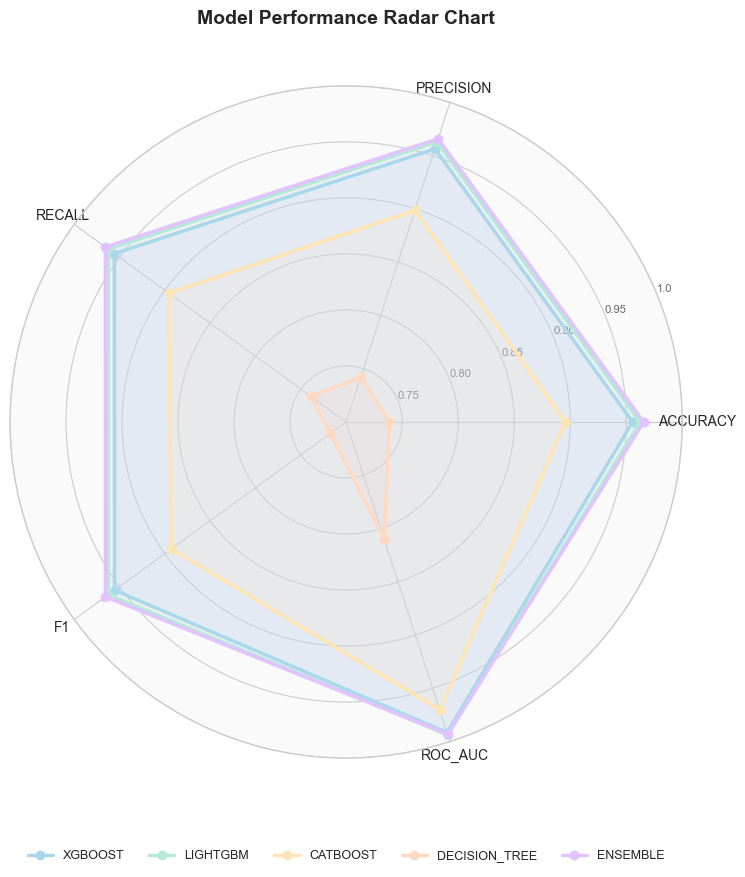

In [11]:
# Radar Chart for Multi-Metric Comparison
from math import pi

# Prepare data
categories = list(metrics_df.columns)
N = len(categories)

# Create angles for radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the loop

# Subtle pastel colors for radar
radar_colors = {
    'xgboost': '#A8D8EA',
    'lightgbm': '#B5EAD7', 
    'catboost': '#FFE5B4',
    'decision_tree': '#FFDAC1',
    'ensemble': '#E2C2FF'
}

fig, ax = plt.subplots(figsize=(10, 9), subplot_kw=dict(polar=True))

# Plot each model
for idx, (model_name, row) in enumerate(metrics_df.iterrows()):
    values = row.values.flatten().tolist()
    values += values[:1]  # Complete the loop
    
    color = radar_colors.get(model_name, '#888888')
    ax.plot(angles, values, 'o-', linewidth=2.5, label=model_name.upper(), color=color, markersize=6)
    ax.fill(angles, values, alpha=0.15, color=color)

# Customize
ax.set_xticks(angles[:-1])
ax.set_xticklabels([c.upper() for c in categories], fontsize=10)
ax.set_ylim(0.7, 1.0)
ax.set_yticks([0.75, 0.80, 0.85, 0.90, 0.95, 1.0])
ax.set_yticklabels(['0.75', '0.80', '0.85', '0.90', '0.95', '1.0'], fontsize=8, alpha=0.7)

# Legend below the chart with more space
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=5, fontsize=9, 
          framealpha=0.95, edgecolor='none', fancybox=True)

plt.title('Model Performance Radar Chart', fontsize=14, fontweight='bold', y=1.08)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.savefig(project_root / 'docs' / 'radar_chart.png', dpi=150, bbox_inches='tight', facecolor='white')
# plt.close()
plt.show()

### 3.3 Model Agreement Heatmap

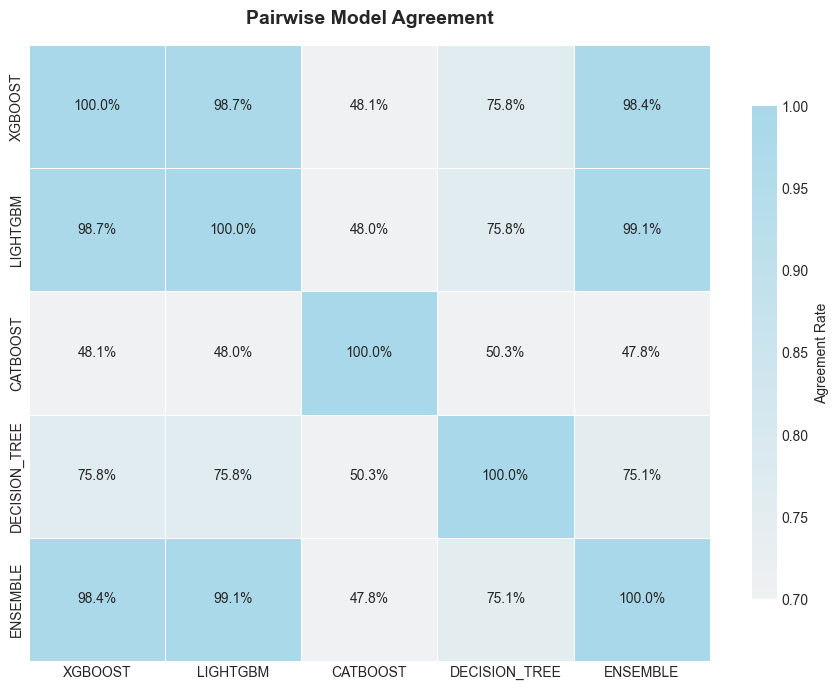

  - XGBoost ↔ LightGBM Agreement: 98.7%
  - Decision Tree ↔ Ensemble Agreement: 75.1%

📊 Key Observations:


In [12]:
# Pairwise Agreement Between Models
model_names = list(model_predictions.keys())
n_models = len(model_names)
agreement_matrix = np.zeros((n_models, n_models))

for i, name1 in enumerate(model_names):
    for j, name2 in enumerate(model_names):
        agreement = (model_predictions[name1] == model_predictions[name2]).mean()
        agreement_matrix[i, j] = agreement

fig, ax = plt.subplots(figsize=(9, 7))

# Create subtle colormap
cmap_agree = sns.light_palette('#A8D8EA', as_cmap=True)
sns.heatmap(agreement_matrix, annot=True, fmt='.1%', cmap=cmap_agree,
            xticklabels=[n.upper() for n in model_names],
            yticklabels=[n.upper() for n in model_names],
            ax=ax, vmin=0.7, vmax=1.0,
            cbar_kws={'label': 'Agreement Rate', 'shrink': 0.8},
            linewidths=0.5, linecolor='white',
            annot_kws={'fontsize': 10})

ax.set_title('Pairwise Model Agreement', fontsize=14, fontweight='bold', pad=15)
ax.tick_params(axis='both', labelsize=10)
plt.tight_layout()
plt.savefig(project_root / 'docs' / 'model_agreement.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# plt.close()
print(f"  - XGBoost ↔ LightGBM Agreement: {agreement_matrix[0, 1]:.1%}")

print(f"  - Decision Tree ↔ Ensemble Agreement: {agreement_matrix[3, 4]:.1%}")
print("\n📊 Key Observations:")

## 4. Ensemble Analysis

### 4.1 Calibration Curves

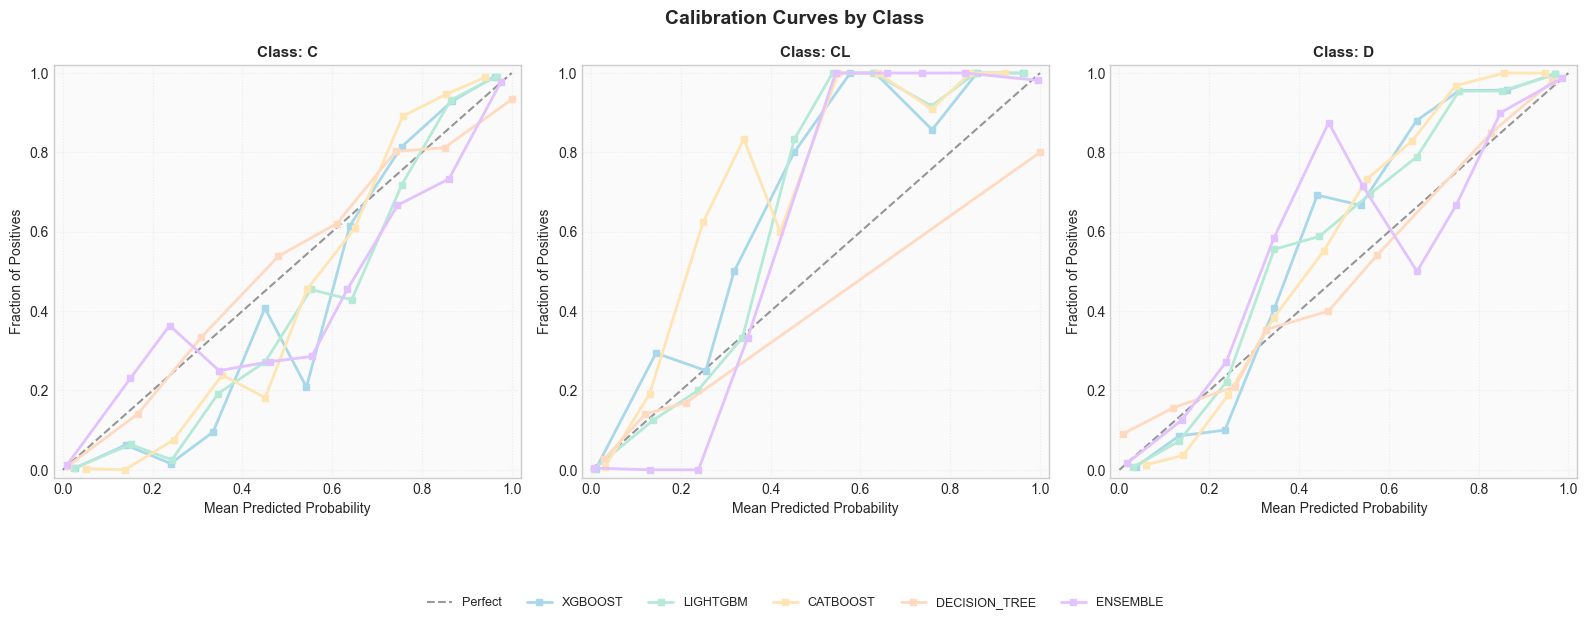

In [13]:
# Calibration Curves
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Subtle colors for calibration
calib_colors = {
    'xgboost': '#A8D8EA',
    'lightgbm': '#B5EAD7', 
    'catboost': '#FFE5B4',
    'decision_tree': '#FFDAC1',
    'ensemble': '#E2C2FF'
}

for cls_idx, cls in enumerate(classes):
    ax = axes[cls_idx]
    
    # Perfect calibration line
    ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.4, label='Perfect')
    
    for name, y_proba in model_probabilities.items():
        # Get calibration curve
        prob_true, prob_pred = calibration_curve(
            y_bin[:, cls_idx], y_proba[:, cls_idx], n_bins=10, strategy='uniform'
        )
        
        color = calib_colors.get(name, '#888888')
        ax.plot(prob_pred, prob_true, 's-', label=name.upper(), color=color, markersize=5, lw=2)
    
    ax.set_xlabel('Mean Predicted Probability', fontsize=10)
    ax.set_ylabel('Fraction of Positives', fontsize=10)
    ax.set_title(f'Class: {cls}', fontsize=11, fontweight='bold')
    ax.set_facecolor('#FAFAFA')
    ax.grid(alpha=0.3, linestyle=':')
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)

# Single legend for all subplots at bottom with proper spacing
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), 
           ncol=6, fontsize=9, framealpha=0.95, edgecolor='none', fancybox=True)

plt.suptitle('Calibration Curves by Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(bottom=0.20)

plt.savefig(project_root / 'docs' / 'calibration_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
# plt.close()
plt.show()

### 4.2 Base Model Contribution to Ensemble

Debug - y_test shape: (1917,)
Debug - Test set size: 1917
  xgboost: Both=1826, BaseOnly=6, EnsOnly=25, BothWrong=60
  lightgbm: Both=1839, BaseOnly=6, EnsOnly=12, BothWrong=60
  catboost: Both=1710, BaseOnly=7, EnsOnly=141, BothWrong=59
  decision_tree: Both=1397, BaseOnly=19, EnsOnly=454, BothWrong=47

Total samples per model should be: 1917
           Model  Both Correct  Base Only Correct  Ensemble Only Correct  \
0        XGBOOST          1826                  6                     25   
1       LIGHTGBM          1839                  6                     12   
2       CATBOOST          1710                  7                    141   
3  DECISION_TREE          1397                 19                    454   

   Both Wrong  
0          60  
1          60  
2          59  
3          47  


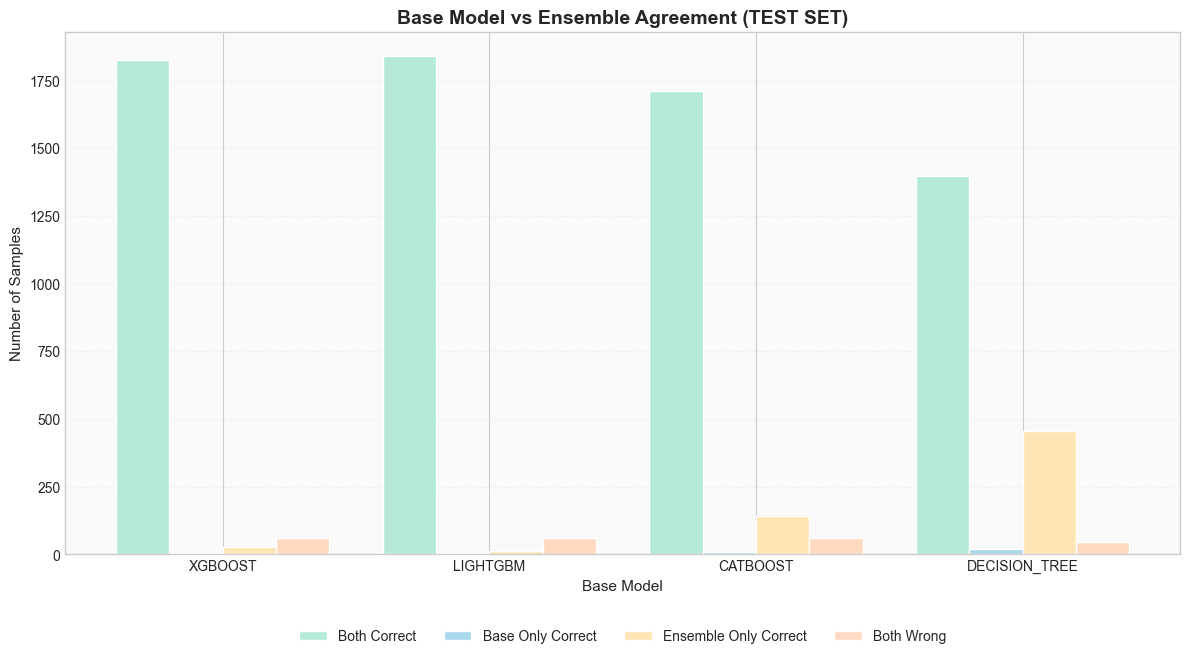

        Model  Both Correct  Base Only Correct  Ensemble Only Correct  Both Wrong
      XGBOOST          1826                  6                     25          60
     LIGHTGBM          1839                  6                     12          60
     CATBOOST          1710                  7                    141          59
DECISION_TREE          1397                 19                    454          47


In [15]:
# Analyze where each base model agrees/disagrees with ensemble (on TEST SET)
base_model_names = [n for n in model_predictions.keys() if n != 'ensemble']

# Debug: Check shapes to ensure proper comparison
print(f"Debug - y_test shape: {np.array(y_test).shape}")
print(f"Debug - Test set size: {len(y_test)}")

# Flatten arrays to ensure 1D comparison
y_test_flat = np.array(y_test).flatten()
ensemble_pred_flat = np.array(model_predictions['ensemble']).flatten()

# Calculate when each model is correct and ensemble is correct
results = []
for name in base_model_names:
    base_pred_flat = np.array(model_predictions[name]).flatten()
    
    base_correct = (base_pred_flat == y_test_flat)
    ensemble_correct = (ensemble_pred_flat == y_test_flat)
    
    both_correct = int((base_correct & ensemble_correct).sum())
    base_only = int((base_correct & ~ensemble_correct).sum())
    ensemble_only = int((~base_correct & ensemble_correct).sum())
    both_wrong = int((~base_correct & ~ensemble_correct).sum())
    
    print(f"  {name}: Both={both_correct}, BaseOnly={base_only}, EnsOnly={ensemble_only}, BothWrong={both_wrong}")
    
    results.append({
        'Model': name.upper(),
        'Both Correct': both_correct,
        'Base Only Correct': base_only,
        'Ensemble Only Correct': ensemble_only,
        'Both Wrong': both_wrong
    })

contrib_df = pd.DataFrame(results)

# Verify the data looks reasonable
print(f"\nTotal samples per model should be: {len(y_test_flat)}")
print(contrib_df)

fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(base_model_names))
width = 0.2

# Subtle pastel colors
contrib_colors = ['#B5EAD7', '#A8D8EA', '#FFE5B4', '#FFDAC1']
categories = ['Both Correct', 'Base Only Correct', 'Ensemble Only Correct', 'Both Wrong']

for i, cat in enumerate(categories):
    vals = contrib_df[cat].values.astype(int)
    bars = ax.bar(x + i * width, vals, width, label=cat, color=contrib_colors[i], edgecolor='white', linewidth=1)

ax.set_ylabel('Number of Samples', fontsize=11)
ax.set_xlabel('Base Model', fontsize=11)
ax.set_title('Base Model vs Ensemble Agreement (TEST SET)', fontsize=14, fontweight='bold')
ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(contrib_df['Model'], fontsize=10)

# Legend below chart with more spacing
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, fontsize=10, 
          framealpha=0.95, edgecolor='none', fancybox=True)

ax.set_facecolor('#FAFAFA')
ax.grid(axis='y', alpha=0.3, linestyle=':')

plt.tight_layout()
plt.subplots_adjust(bottom=0.20)
plt.savefig(project_root / 'docs' / 'base_model_contribution.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

print(contrib_df.to_string(index=False))

## 5. Feature Importance & Interpretability

### 5.1 Feature Importance Comparison

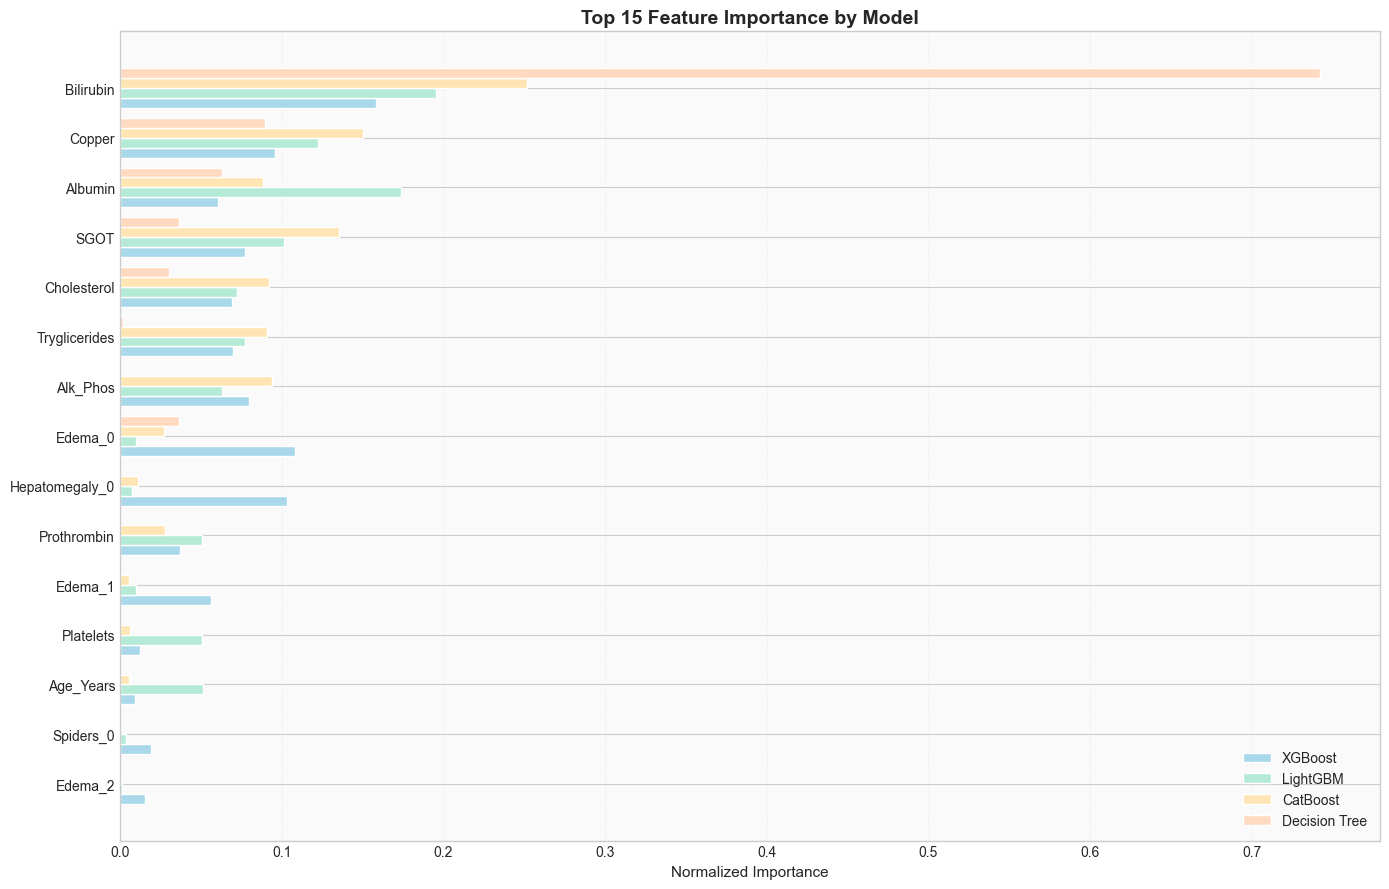


📊 Top 10 Features (Average Importance):
Bilirubin         0.337046
Copper            0.114626
Albumin           0.096595
SGOT              0.087743
Cholesterol       0.066188
Tryglicerides     0.059963
Alk_Phos          0.059258
Edema_0           0.045281
Hepatomegaly_0    0.030505
Prothrombin       0.028937


In [16]:
# Get feature names (models are already trained, just extract importance)
feature_names = ml_service.feature_names_

# Extract feature importance from already-trained models
importance_dict = {}

# XGBoost
importance_dict['XGBoost'] = base_models['xgboost'].feature_importances_

# LightGBM
importance_dict['LightGBM'] = base_models['lightgbm'].feature_importances_

# CatBoost
importance_dict['CatBoost'] = base_models['catboost'].feature_importances_

# Decision Tree
importance_dict['Decision Tree'] = base_models['decision_tree'].feature_importances_

# Normalize importances
for key in importance_dict:
    importance_dict[key] = importance_dict[key] / importance_dict[key].sum()

importance_df = pd.DataFrame(importance_dict, index=feature_names)
importance_df['Average'] = importance_df.mean(axis=1)
importance_df = importance_df.sort_values('Average', ascending=True)

# Plot top 15 features
top_n = 15
top_features = importance_df.tail(top_n)

fig, ax = plt.subplots(figsize=(14, 9))

y_pos = np.arange(len(top_features))
width = 0.2

# Subtle pastel colors
fi_colors = ['#A8D8EA', '#B5EAD7', '#FFE5B4', '#FFDAC1']
models = ['XGBoost', 'LightGBM', 'CatBoost', 'Decision Tree']

for i, model in enumerate(models):
    ax.barh(y_pos + i * width, top_features[model], width, 
            label=model, color=fi_colors[i], edgecolor='white', linewidth=1)

ax.set_yticks(y_pos + 1.5 * width)
ax.set_yticklabels(top_features.index, fontsize=10)
ax.set_xlabel('Normalized Importance', fontsize=11)
ax.set_title(f'Top {top_n} Feature Importance by Model', fontsize=14, fontweight='bold')

# Legend in a non-overlapping position
ax.legend(loc='lower right', fontsize=10, framealpha=0.95, edgecolor='none', fancybox=True)

ax.set_facecolor('#FAFAFA')
ax.grid(axis='x', alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig(project_root / 'docs' / 'feature_importance.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

print("\n📊 Top 10 Features (Average Importance):")
print(importance_df['Average'].tail(10).sort_values(ascending=False).to_string())

### 5.2 Decision Tree Visualization

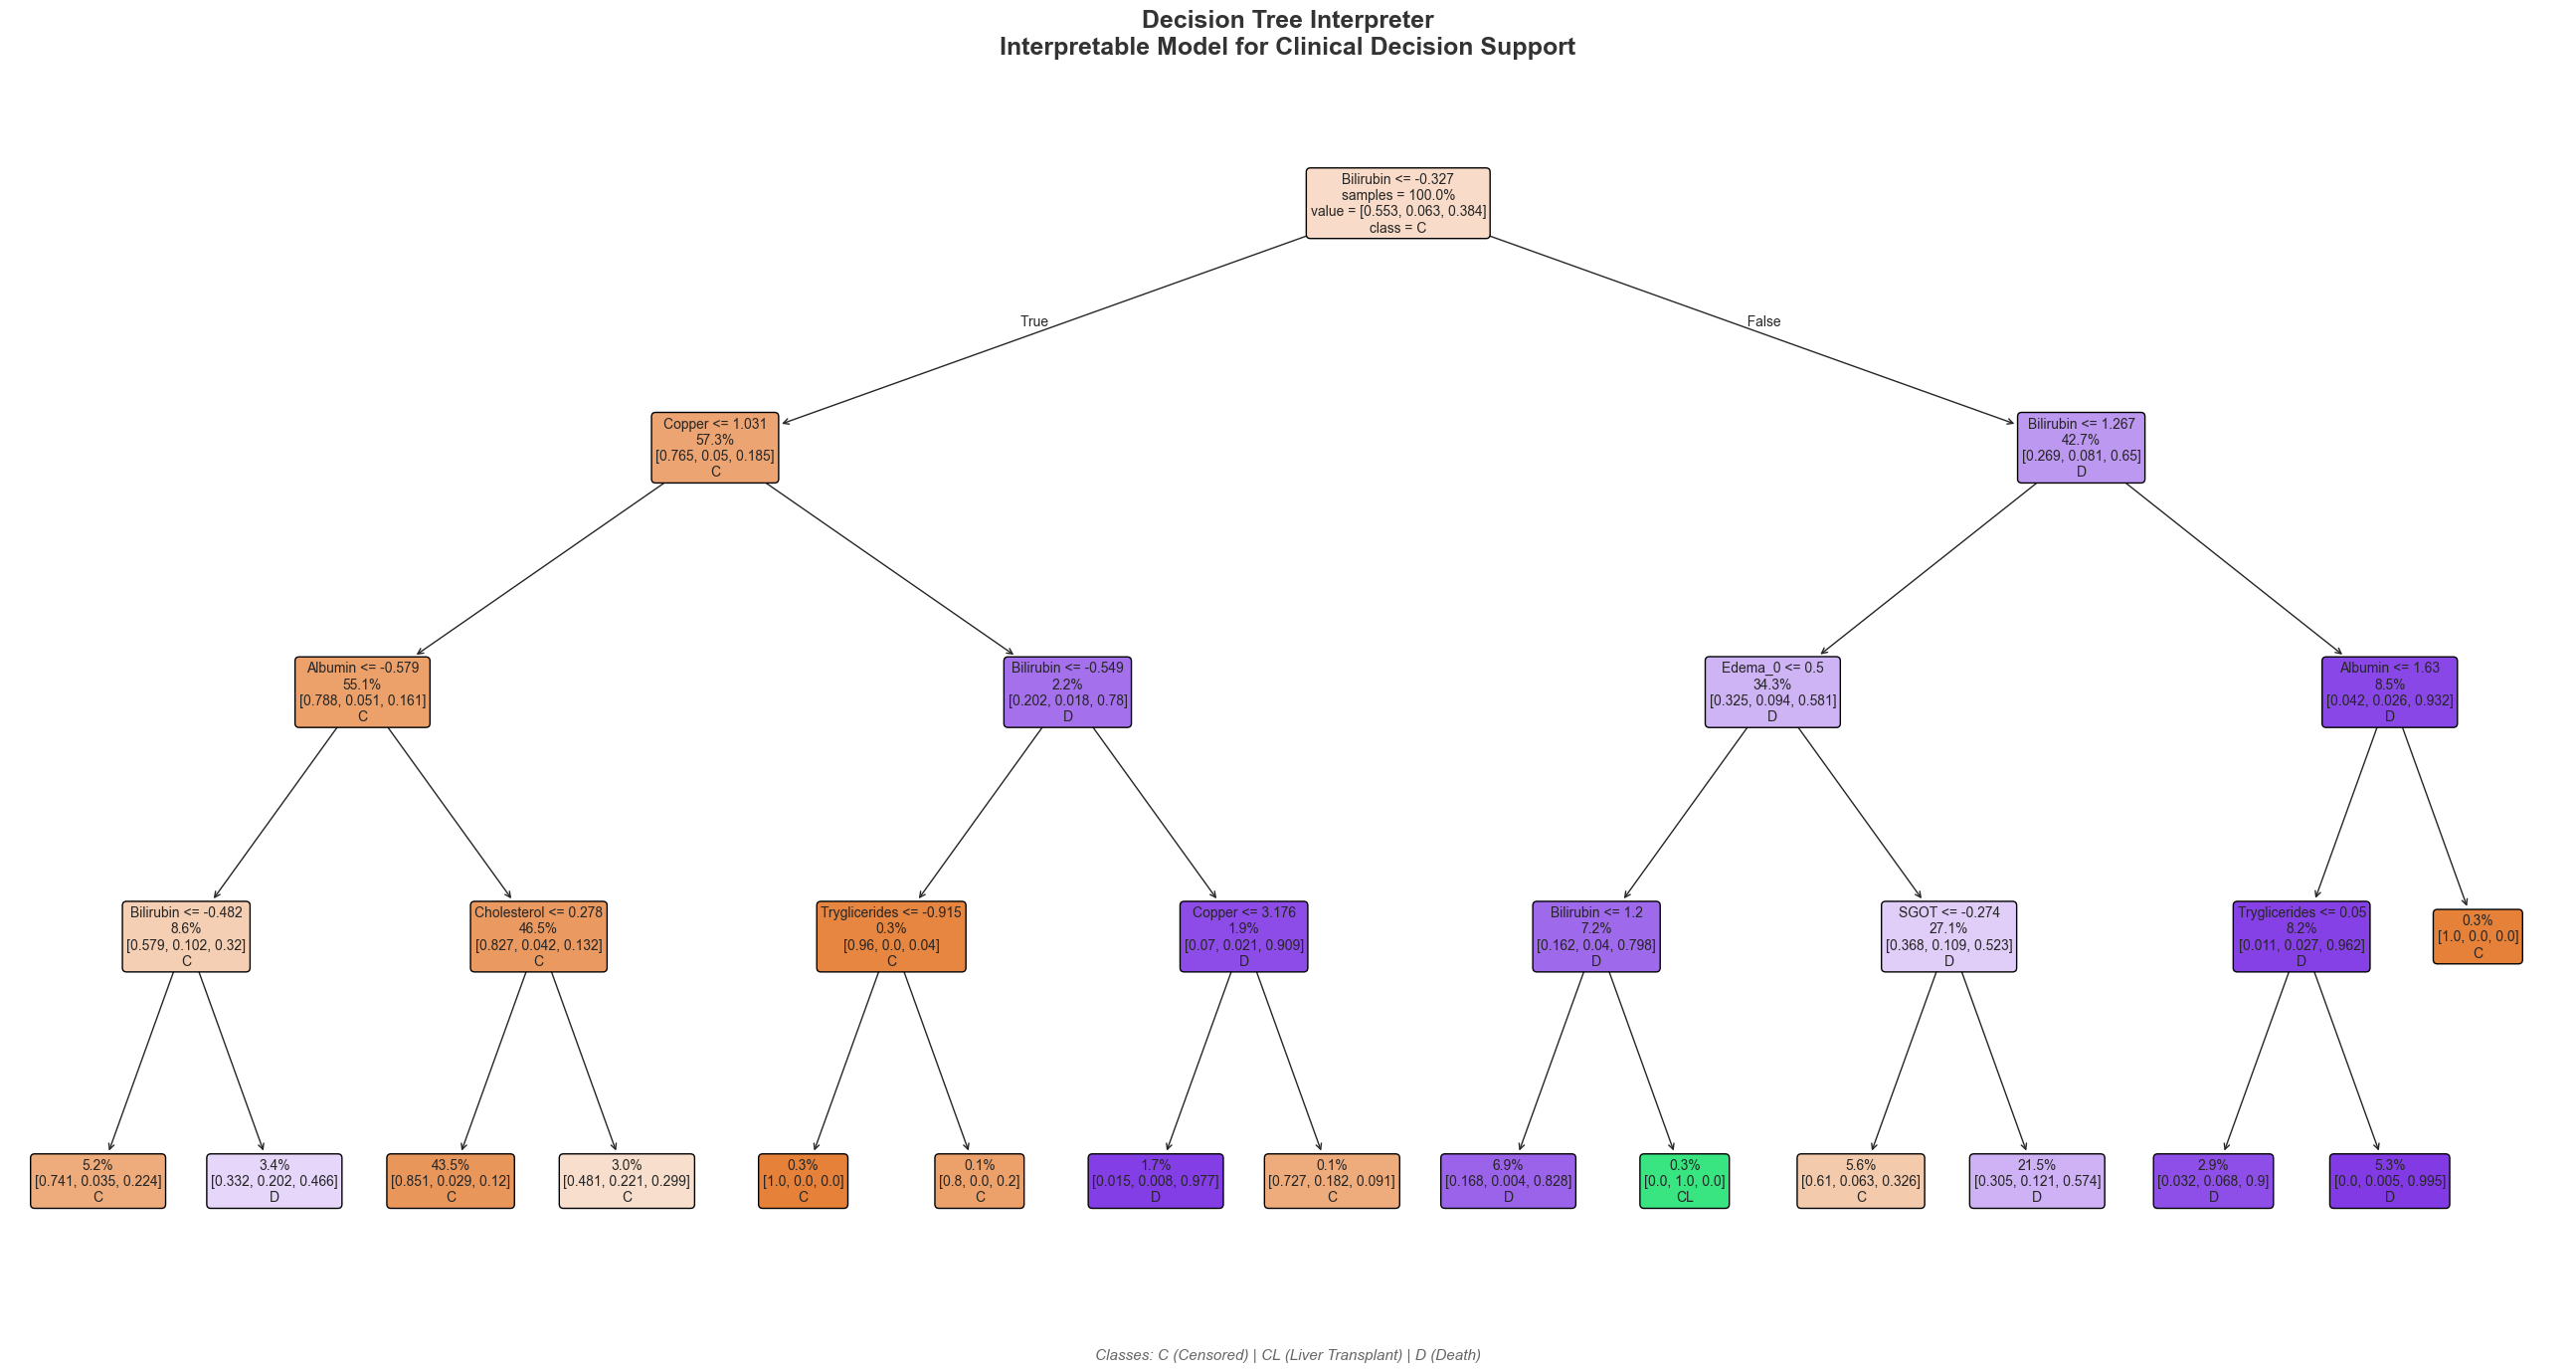

In [18]:
from sklearn.tree import plot_tree
import matplotlib.colors as mcolors

# Visualize the Decision Tree (Interpreter) with subtle pastel colors
fig, ax = plt.subplots(figsize=(26, 14), facecolor='white')
ax.set_facecolor('#FAFAFA')

# Create a custom subtle colormap for the tree nodes
# Classes: C (Censored), CL (Censored due to Liver), D (Death)
# Using soft pastel: mint, peach, lavender
from matplotlib.colors import LinearSegmentedColormap

plot_tree(base_models['decision_tree'], 
          feature_names=feature_names,
          class_names=list(classes),
          filled=True,
          rounded=True,
          fontsize=10,
          ax=ax,
          proportion=True,
          impurity=False,  # Cleaner look without impurity
          label='root')

# Style the tree nodes with softer colors
# Get all the artists and modify rectangle colors
for artist in ax.get_children():
    if hasattr(artist, 'get_facecolor'):
        fc = artist.get_facecolor()
        if isinstance(fc, np.ndarray) and len(fc) == 4:
            # Soften the colors by blending with white
            new_color = fc.copy()
            new_color[:3] = fc[:3] * 0.6 + 0.4  # Blend towards white
            new_color[3] = 0.85  # Slightly transparent
            artist.set_facecolor(new_color)
            artist.set_edgecolor('#CCCCCC')
            artist.set_linewidth(1.5)

plt.title('Decision Tree Interpreter\nInterpretable Model for Clinical Decision Support', 
          fontsize=18, fontweight='bold', color='#333333', pad=20)

# Add a subtle legend
legend_text = "Classes: C (Censored) | CL (Liver Transplant) | D (Death)"
fig.text(0.5, 0.02, legend_text, ha='center', fontsize=11, 
         color='#666666', style='italic')

plt.tight_layout()
plt.subplots_adjust(bottom=0.06)
plt.savefig(project_root / 'docs' / 'decision_tree.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

### 5.3 Decision Tree Rules Extraction

In [19]:
from sklearn.tree import export_text

# Extract and print decision tree rules
tree_rules = export_text(base_models['decision_tree'], 
                         feature_names=feature_names,
                         class_names=list(classes))

print("📋 Decision Tree Rules (Interpretable Model):")
print("=" * 60)
print(tree_rules)

📋 Decision Tree Rules (Interpretable Model):
|--- Bilirubin <= -0.33
|   |--- Copper <= 1.03
|   |   |--- Albumin <= -0.58
|   |   |   |--- Bilirubin <= -0.48
|   |   |   |   |--- class: C
|   |   |   |--- Bilirubin >  -0.48
|   |   |   |   |--- class: D
|   |   |--- Albumin >  -0.58
|   |   |   |--- Cholesterol <= 0.28
|   |   |   |   |--- class: C
|   |   |   |--- Cholesterol >  0.28
|   |   |   |   |--- class: C
|   |--- Copper >  1.03
|   |   |--- Bilirubin <= -0.55
|   |   |   |--- Tryglicerides <= -0.92
|   |   |   |   |--- class: C
|   |   |   |--- Tryglicerides >  -0.92
|   |   |   |   |--- class: C
|   |   |--- Bilirubin >  -0.55
|   |   |   |--- Copper <= 3.18
|   |   |   |   |--- class: D
|   |   |   |--- Copper >  3.18
|   |   |   |   |--- class: C
|--- Bilirubin >  -0.33
|   |--- Bilirubin <= 1.27
|   |   |--- Edema_0 <= 0.50
|   |   |   |--- Bilirubin <= 1.20
|   |   |   |   |--- class: D
|   |   |   |--- Bilirubin >  1.20
|   |   |   |   |--- class: CL
|   |   |--- Edema

## 6. Error Analysis

### 6.1 Misclassification Analysis

In [20]:
# Analyze misclassifications by the ensemble (on TEST SET)
y_pred_ensemble = model_predictions['ensemble']
misclassified_mask = y_pred_ensemble != y_test

print(f"📊 Misclassification Summary (TEST SET):")
print(f"  Total test samples: {len(y_test)}")
print(f"  Correctly classified: {(~misclassified_mask).sum()} ({(~misclassified_mask).mean():.2%})")
print(f"  Misclassified: {misclassified_mask.sum()} ({misclassified_mask.mean():.2%})")

# Misclassification breakdown
print(f"\n📋 Misclassification Breakdown:")
for true_cls in range(n_classes):
    for pred_cls in range(n_classes):
        if true_cls != pred_cls:
            count = ((y_test == true_cls) & (y_pred_ensemble == pred_cls)).sum()
            if count > 0:
                print(f"  {classes[true_cls]} → {classes[pred_cls]}: {count}")

📊 Misclassification Summary (TEST SET):
  Total test samples: 1917
  Correctly classified: 1851 (96.56%)
  Misclassified: 66 (3.44%)

📋 Misclassification Breakdown:
  C → CL: 3
  C → D: 18
  CL → C: 8
  CL → D: 1
  D → C: 36


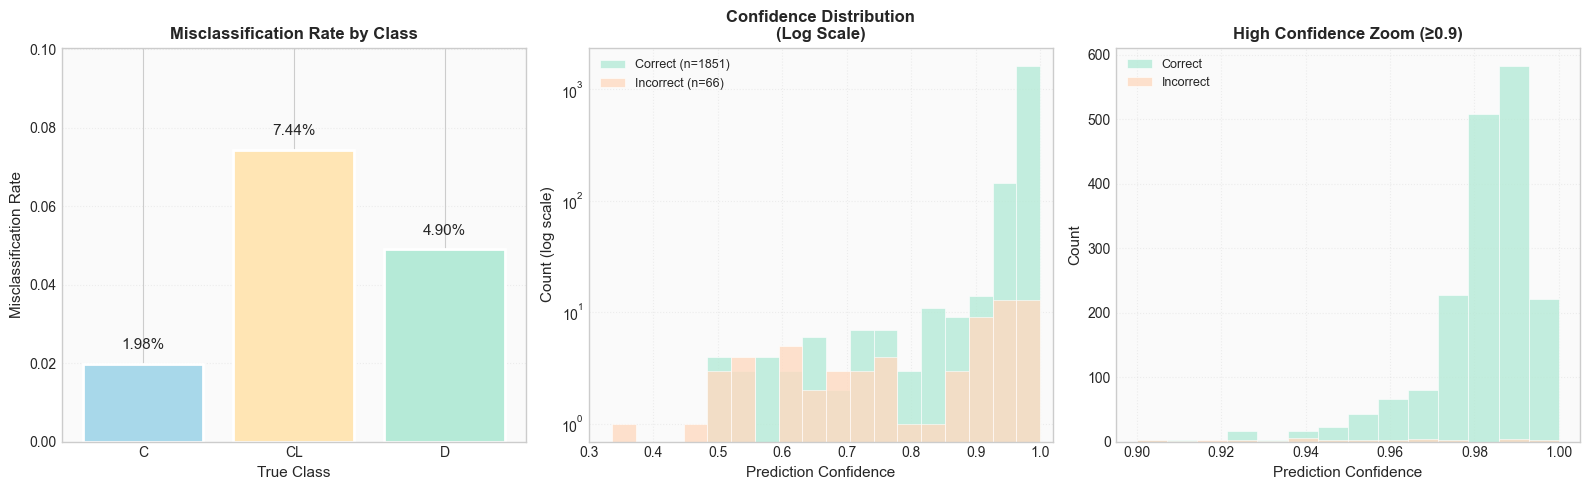


📊 Confidence Statistics (TEST SET):
  Total samples: 1917
  Correct: 1851 (96.6%)
  Incorrect: 66 (3.4%)

  Correct predictions - Mean confidence: 0.973
  Incorrect predictions - Mean confidence: 0.812


In [24]:
# Visualize misclassification patterns (on TEST SET)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Subtle pastel colors for classes
misclass_colors = ['#A8D8EA', '#FFE5B4', '#B5EAD7']

# 1. Misclassification by true class
ax1 = axes[0]
misclass_by_true = []
for i, cls in enumerate(classes):
    mask = y_test == i
    misclass_rate = (y_pred_ensemble[mask] != y_test[mask]).mean()
    misclass_by_true.append(misclass_rate)

bars = ax1.bar(classes, misclass_by_true, color=misclass_colors, edgecolor='white', linewidth=2)
ax1.set_ylabel('Misclassification Rate', fontsize=11)
ax1.set_xlabel('True Class', fontsize=11)
ax1.set_title('Misclassification Rate by Class', fontsize=12, fontweight='bold')
for bar, val in zip(bars, misclass_by_true):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003, 
             f'{val:.2%}', ha='center', va='bottom', fontsize=11, fontweight='medium')
ax1.set_facecolor('#FAFAFA')
ax1.set_ylim(0, max(misclass_by_true) * 1.35 if max(misclass_by_true) > 0 else 0.1)
ax1.grid(axis='y', alpha=0.3, linestyle=':')

# 2. Confidence distribution (full view with log scale for visibility)
ax2 = axes[1]
y_proba_ensemble = model_probabilities['ensemble']
confidence = y_proba_ensemble.max(axis=1)

# Use fewer bins and focus on the full range
bins = np.linspace(0.3, 1.0, 20)
ax2.hist(confidence[~misclassified_mask], bins=bins, alpha=0.8, 
         label=f'Correct (n={int((~misclassified_mask).sum())})', 
         color='#B5EAD7', edgecolor='white', linewidth=0.5)
ax2.hist(confidence[misclassified_mask], bins=bins, alpha=0.8, 
         label=f'Incorrect (n={int(misclassified_mask.sum())})', 
         color='#FFDAC1', edgecolor='white', linewidth=0.5)
ax2.set_xlabel('Prediction Confidence', fontsize=11)
ax2.set_ylabel('Count (log scale)', fontsize=11)
ax2.set_yscale('log')  # Log scale to see small counts
ax2.set_title('Confidence Distribution\n(Log Scale)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9, loc='upper left', framealpha=0.95, edgecolor='none')
ax2.set_facecolor('#FAFAFA')
ax2.grid(alpha=0.3, linestyle=':')
ax2.set_xlim(0.3, 1.02)

# 3. Zoomed view of high-confidence region
ax3 = axes[2]
high_conf_mask = confidence >= 0.9
bins_zoom = np.linspace(0.9, 1.0, 15)
ax3.hist(confidence[(~misclassified_mask) & high_conf_mask], bins=bins_zoom, alpha=0.8,
         label='Correct', color='#B5EAD7', edgecolor='white', linewidth=0.5)
ax3.hist(confidence[misclassified_mask & high_conf_mask], bins=bins_zoom, alpha=0.8,
         label='Incorrect', color='#FFDAC1', edgecolor='white', linewidth=0.5)
ax3.set_xlabel('Prediction Confidence', fontsize=11)
ax3.set_ylabel('Count', fontsize=11)
ax3.set_title('High Confidence Zoom (≥0.9)', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9, loc='upper left', framealpha=0.95, edgecolor='none')
ax3.set_facecolor('#FAFAFA')
ax3.grid(alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig(project_root / 'docs' / 'error_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

print(f"\n📊 Confidence Statistics (TEST SET):")
print(f"  Total samples: {len(confidence)}")
print(f"  Correct: {(~misclassified_mask).sum()} ({(~misclassified_mask).mean():.1%})")
print(f"  Incorrect: {misclassified_mask.sum()} ({misclassified_mask.mean():.1%})")
print(f"\n  Correct predictions - Mean confidence: {confidence[~misclassified_mask].mean():.3f}")
if misclassified_mask.sum() > 0:
    print(f"  Incorrect predictions - Mean confidence: {confidence[misclassified_mask].mean():.3f}")
else:
    print(f"  No incorrect predictions on test set!")

### 6.2 Per-Class Performance Summary

In [25]:
# Detailed per-class metrics for ensemble (on TEST SET)
print("📊 ENSEMBLE - Per-Class Performance (HELD-OUT TEST SET):")
print("=" * 60)
print(classification_report(y_test, y_pred_ensemble, target_names=classes, digits=4))

📊 ENSEMBLE - Per-Class Performance (HELD-OUT TEST SET):
              precision    recall  f1-score   support

           C     0.9594    0.9802    0.9697      1061
          CL     0.9739    0.9256    0.9492       121
           D     0.9735    0.9510    0.9621       735

    accuracy                         0.9656      1917
   macro avg     0.9690    0.9523    0.9603      1917
weighted avg     0.9657    0.9656    0.9655      1917



## 📋 Summary Dashboard

✅ Visualizations saved to docs/ folder!
✅ All metrics are on HELD-OUT TEST SET - These are HONEST!



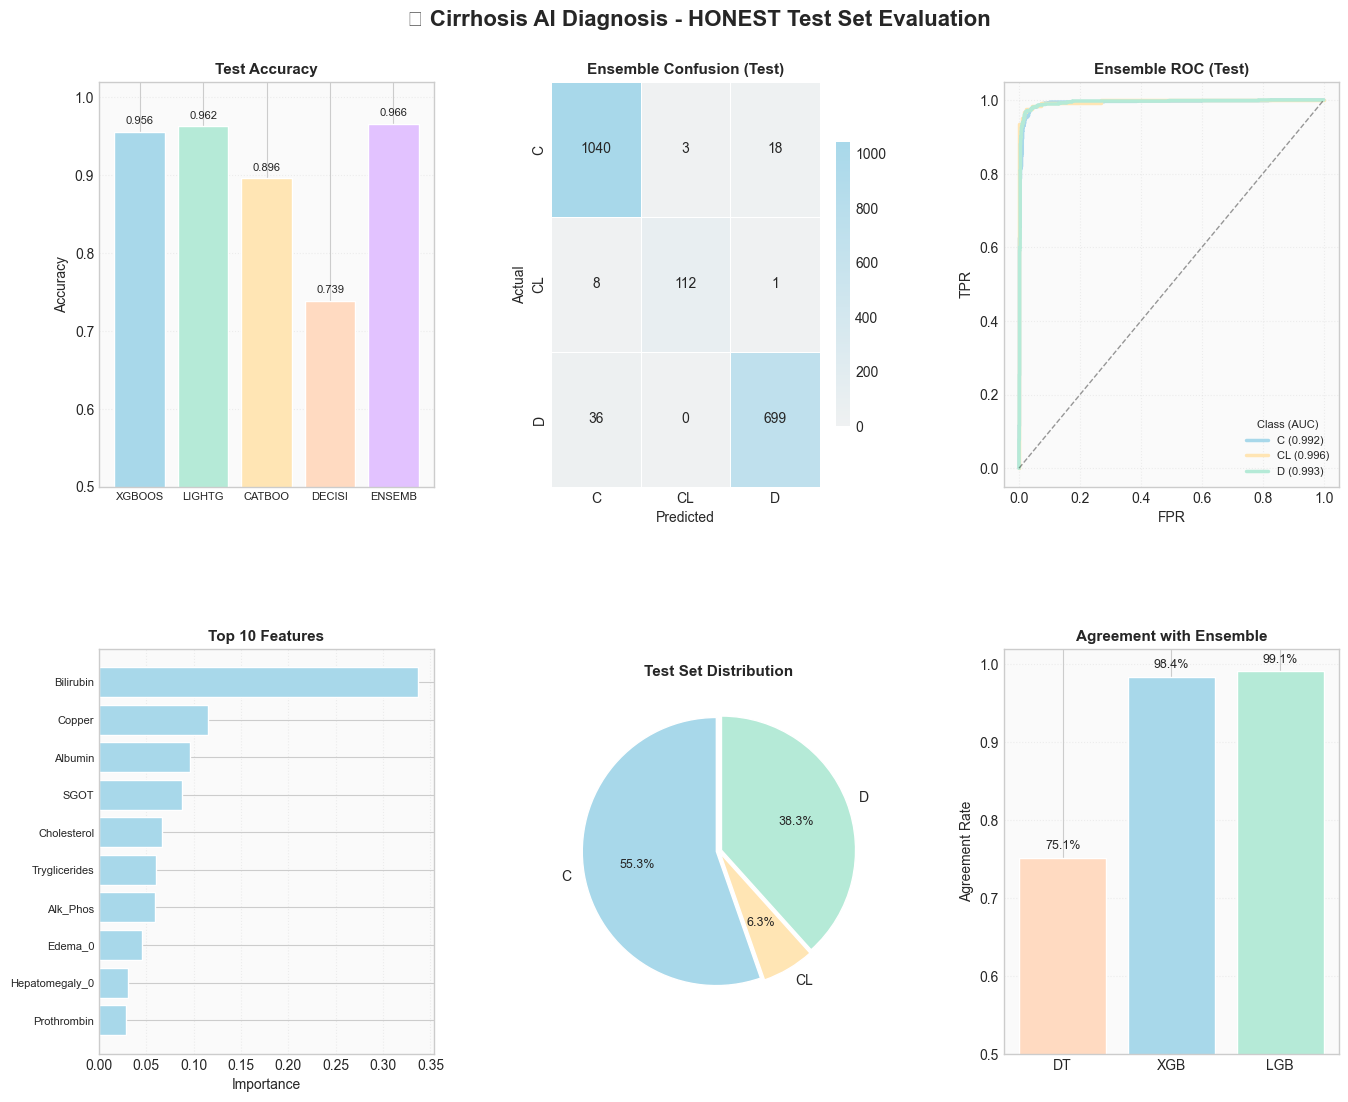

In [26]:
# Create a summary dashboard (all metrics on HELD-OUT TEST SET)
fig = plt.figure(figsize=(16, 12))

# Subtle pastel colors
dash_colors = {
    'xgboost': '#A8D8EA',
    'lightgbm': '#B5EAD7', 
    'catboost': '#FFE5B4',
    'decision_tree': '#FFDAC1',
    'ensemble': '#E2C2FF'
}
dash_class_colors = ['#A8D8EA', '#FFE5B4', '#B5EAD7']

# Layout: 2x3 grid
gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.35)

# 1. Model Comparison Bar
ax1 = fig.add_subplot(gs[0, 0])
models = list(model_metrics.keys())
accuracies = [model_metrics[m]['accuracy'] for m in models]
colors_list = [dash_colors.get(m, '#888888') for m in models]
bars = ax1.bar([m.upper()[:6] for m in models], accuracies, color=colors_list, edgecolor='white', linewidth=1)
ax1.set_ylabel('Accuracy', fontsize=10)
ax1.set_title('Test Accuracy', fontweight='bold', fontsize=11)
ax1.set_ylim(0.5, 1.02)
ax1.tick_params(axis='x', labelsize=8)
for bar, val in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.008, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=8)
ax1.set_facecolor('#FAFAFA')
ax1.grid(axis='y', alpha=0.3, linestyle=':')

# 2. Ensemble Confusion Matrix (TEST SET)
ax2 = fig.add_subplot(gs[0, 1])
cm = confusion_matrix(y_test, y_pred_ensemble)
cmap_dash = sns.light_palette('#A8D8EA', as_cmap=True)
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap_dash, ax=ax2,
            xticklabels=classes, yticklabels=classes, cbar_kws={'shrink': 0.7},
            linewidths=0.5, linecolor='white')
ax2.set_title('Ensemble Confusion (Test)', fontweight='bold', fontsize=11)
ax2.set_xlabel('Predicted', fontsize=10)
ax2.set_ylabel('Actual', fontsize=10)

# 3. ROC Curves (Ensemble only)
ax3 = fig.add_subplot(gs[0, 2])
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba_ensemble[:, i])
    roc_auc = auc(fpr, tpr)
    ax3.plot(fpr, tpr, color=dash_class_colors[i], lw=2.5, label=f'{cls} ({roc_auc:.3f})')
ax3.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.4)
ax3.set_xlabel('FPR', fontsize=10)
ax3.set_ylabel('TPR', fontsize=10)
ax3.set_title('Ensemble ROC (Test)', fontweight='bold', fontsize=11)
ax3.legend(loc='lower right', fontsize=8, title='Class (AUC)', title_fontsize=8, 
           framealpha=0.95, edgecolor='none')
ax3.set_facecolor('#FAFAFA')
ax3.grid(alpha=0.3, linestyle=':')

# 4. Feature Importance (Top 10)
ax4 = fig.add_subplot(gs[1, 0])
top_10 = importance_df['Average'].tail(10)
ax4.barh(range(len(top_10)), top_10.values, color='#A8D8EA', edgecolor='white', linewidth=1)
ax4.set_yticks(range(len(top_10)))
ax4.set_yticklabels(top_10.index, fontsize=8)
ax4.set_xlabel('Importance', fontsize=10)
ax4.set_title('Top 10 Features', fontweight='bold', fontsize=11)
ax4.set_facecolor('#FAFAFA')
ax4.grid(axis='x', alpha=0.3, linestyle=':')

# 5. Test Set Class Distribution
ax5 = fig.add_subplot(gs[1, 1])
class_counts = [np.sum(y_test == i) for i in range(n_classes)]
wedges, texts, autotexts = ax5.pie(class_counts, labels=classes, colors=dash_class_colors, 
                                    autopct='%1.1f%%', startangle=90, explode=[0.02]*n_classes,
                                    textprops={'fontsize': 10}, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
for autotext in autotexts:
    autotext.set_fontsize(9)
    autotext.set_fontweight('medium')
ax5.set_title('Test Set Distribution', fontweight='bold', fontsize=11)

# 6. Model Agreement
ax6 = fig.add_subplot(gs[1, 2])
dt_ensemble_agree = (model_predictions['decision_tree'] == model_predictions['ensemble']).mean()
xgb_ensemble_agree = (model_predictions['xgboost'] == model_predictions['ensemble']).mean()
lgb_ensemble_agree = (model_predictions['lightgbm'] == model_predictions['ensemble']).mean()

agree_data = [dt_ensemble_agree, xgb_ensemble_agree, lgb_ensemble_agree]
agree_labels = ['DT', 'XGB', 'LGB']
agree_colors = ['#FFDAC1', '#A8D8EA', '#B5EAD7']

bars = ax6.bar(agree_labels, agree_data, color=agree_colors, edgecolor='white', linewidth=1)
ax6.set_ylabel('Agreement Rate', fontsize=10)
ax6.set_title('Agreement with Ensemble', fontweight='bold', fontsize=11)
ax6.set_ylim(0.5, 1.02)
for bar, val in zip(bars, agree_data):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.008, 
             f'{val:.1%}', ha='center', va='bottom', fontsize=9)
ax6.set_facecolor('#FAFAFA')
ax6.grid(axis='y', alpha=0.3, linestyle=':')


plt.suptitle('🏥 Cirrhosis AI Diagnosis - HONEST Test Set Evaluation',fontsize=16, fontweight='bold')
print("=" * 60)
print("✅ Visualizations saved to docs/ folder!")

plt.tight_layout()
print("✅ All metrics are on HELD-OUT TEST SET - These are HONEST!")

plt.subplots_adjust(top=0.92)
print("\n" + "=" * 60)

plt.savefig(project_root / 'docs' / 'evaluation_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')

plt.show()
plt.close()

### 7.1 Train vs Validation Metrics Per Fold

In [27]:
# Train vs Validation metrics per fold - Detects overfitting!
from sklearn.model_selection import cross_validate
from sklearn.base import clone

# Load training data for CV analysis
data_path = project_root / "data" / "processed" / "cirrhosis_cleaned.csv"
df_full = pd.read_csv(data_path)
df_full = df_full.drop(columns=['ID', 'N_Days'], errors='ignore')
df_full = df_full.dropna(subset=['Status'])

X_full = df_full[ml_service.numerical_features + ml_service.categorical_features].copy()
y_full = df_full['Status'].copy()

# Use the loaded preprocessor
X_full_processed = ml_service.preprocessor.transform(X_full)
y_full_encoded = ml_service.label_encoder.transform(y_full)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Collect train vs val scores for each model
cv_results = {}
print("📊 Cross-Validation: Train vs Validation Scores")
print("=" * 70)
print(f"{'Model':<15} {'Train Acc':<12} {'Val Acc':<12} {'Gap':<10} {'Status'}")
print("-" * 70)

for name, model in base_models.items():
    # Clone to avoid retraining the saved model
    model_clone = clone(model)
    
    scores = cross_validate(
        model_clone, X_full_processed, y_full_encoded, 
        cv=cv, scoring='accuracy',
        return_train_score=True
    )
    
    train_mean = scores['train_score'].mean()
    val_mean = scores['test_score'].mean()
    train_std = scores['train_score'].std()
    val_std = scores['test_score'].std()
    gap = train_mean - val_mean
    
    cv_results[name] = {
        'train_scores': scores['train_score'],
        'val_scores': scores['test_score'],
        'train_mean': train_mean,
        'val_mean': val_mean,
        'gap': gap
    }
    
    # Assess overfitting
    if gap > 0.10:
        status = "⚠️ OVERFITTING"
    elif gap > 0.05:
        status = "⚡ Slight overfit"
    else:
        status = "✅ Good"
    
    print(f"{name:<15} {train_mean:.4f}±{train_std:.3f}  {val_mean:.4f}±{val_std:.3f}  {gap:+.4f}    {status}")

print("-" * 70)
print("\n💡 Gap = Train - Val. Large gap (>5%) suggests overfitting.")

📊 Cross-Validation: Train vs Validation Scores
Model           Train Acc    Val Acc      Gap        Status
----------------------------------------------------------------------
xgboost         0.9780±0.002  0.9610±0.004  +0.0170    ✅ Good
xgboost         0.9780±0.002  0.9610±0.004  +0.0170    ✅ Good
lightgbm        0.9834±0.001  0.9663±0.005  +0.0171    ✅ Good
lightgbm        0.9834±0.001  0.9663±0.005  +0.0171    ✅ Good
catboost        0.9065±0.002  0.8916±0.003  +0.0149    ✅ Good
decision_tree   0.7612±0.004  0.7538±0.009  +0.0074    ✅ Good
----------------------------------------------------------------------

💡 Gap = Train - Val. Large gap (>5%) suggests overfitting.
catboost        0.9065±0.002  0.8916±0.003  +0.0149    ✅ Good
decision_tree   0.7612±0.004  0.7538±0.009  +0.0074    ✅ Good
----------------------------------------------------------------------

💡 Gap = Train - Val. Large gap (>5%) suggests overfitting.


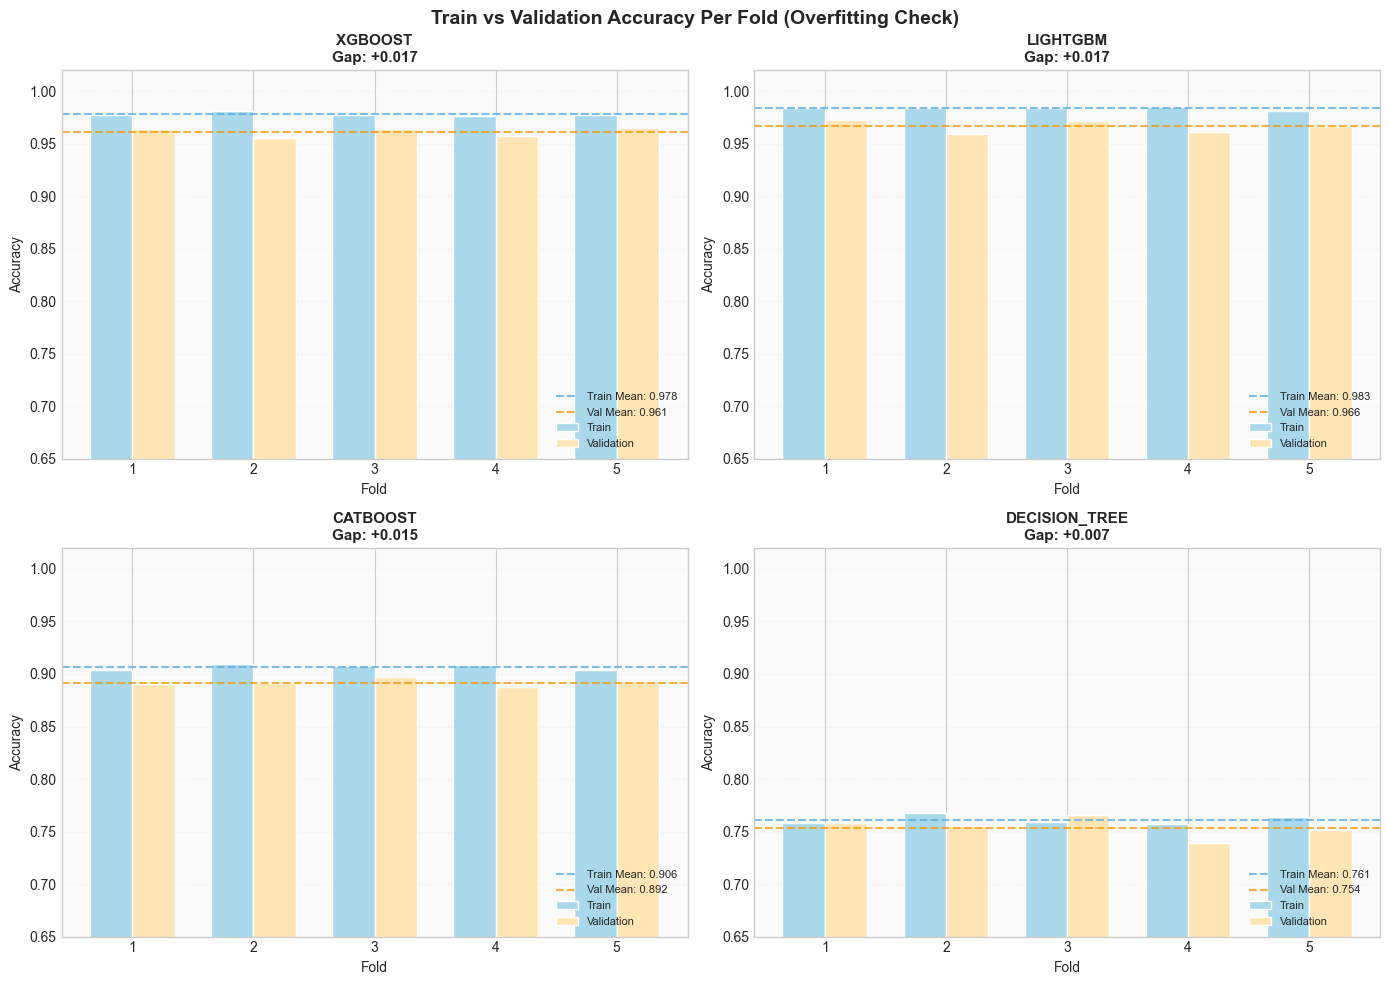


✅ Small, consistent gaps across folds = No overfitting!


In [28]:
# Visualize Train vs Validation per fold
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, results) in enumerate(cv_results.items()):
    ax = axes[idx]
    folds = np.arange(1, 6)
    width = 0.35
    
    train_bars = ax.bar(folds - width/2, results['train_scores'], width, 
                        label='Train', color='#A8D8EA', edgecolor='white', linewidth=1)
    val_bars = ax.bar(folds + width/2, results['val_scores'], width,
                      label='Validation', color='#FFE5B4', edgecolor='white', linewidth=1)
    
    ax.axhline(y=results['train_mean'], color='#5DADE2', linestyle='--', alpha=0.8, lw=1.5,
               label=f'Train Mean: {results["train_mean"]:.3f}')
    ax.axhline(y=results['val_mean'], color='#F39C12', linestyle='--', alpha=0.8, lw=1.5,
               label=f'Val Mean: {results["val_mean"]:.3f}')
    
    ax.set_xlabel('Fold', fontsize=10)
    ax.set_ylabel('Accuracy', fontsize=10)
    ax.set_title(f'{name.upper()}\nGap: {results["gap"]:+.3f}', fontsize=11, fontweight='bold')
    ax.set_xticks(folds)
    ax.set_ylim(0.65, 1.02)
    ax.legend(loc='lower right', fontsize=8, framealpha=0.95, edgecolor='none')
    ax.set_facecolor('#FAFAFA')
    ax.grid(axis='y', alpha=0.3, linestyle=':')

plt.suptitle('Train vs Validation Accuracy Per Fold (Overfitting Check)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig(project_root / 'docs' / 'train_val_per_fold.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

print("\n✅ Small, consistent gaps across folds = No overfitting!")

### 7.2 Feature Importance Stability Across Folds

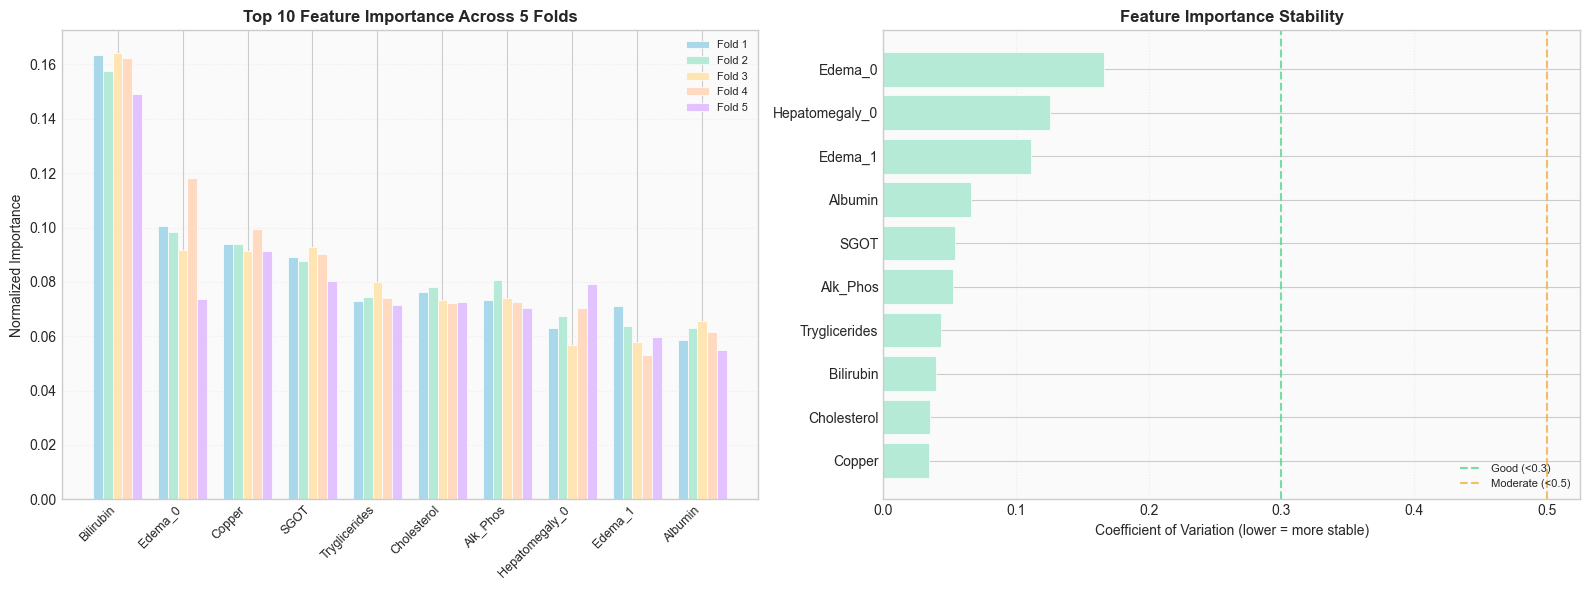


📊 Feature Stability Summary:
   Least stable: Edema_2 (CV=0.804)
   Stable features (CV < 0.3): 15/23
   Most stable: Copper (CV=0.035)


In [29]:
# Feature Importance Stability - If rankings change wildly across folds, model is unstable
from sklearn.base import clone

# Collect feature importance across folds for XGBoost
fold_importances = []

for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_full_processed, y_full_encoded)):
    X_train_fold = X_full_processed[train_idx]
    y_train_fold = y_full_encoded[train_idx]
    
    # Train XGBoost on this fold
    xgb_fold = clone(base_models['xgboost'])
    xgb_fold.fit(X_train_fold, y_train_fold)
    
    # Get normalized importance
    imp = xgb_fold.feature_importances_
    imp_normalized = imp / imp.sum()
    fold_importances.append(imp_normalized)

# Create DataFrame
stability_df = pd.DataFrame(fold_importances, columns=feature_names)
stability_df.index = [f'Fold {i+1}' for i in range(5)]

# Calculate stability metrics
mean_importance = stability_df.mean()
std_importance = stability_df.std()
cv_importance = std_importance / mean_importance  # Coefficient of variation

# Plot stability
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 features importance across folds
ax1 = axes[0]
top_10_features = mean_importance.nlargest(10).index.tolist()
stability_top10 = stability_df[top_10_features]

x = np.arange(len(top_10_features))
width = 0.15

fold_colors_subtle = ['#A8D8EA', '#B5EAD7', '#FFE5B4', '#FFDAC1', '#E2C2FF']

for i in range(5):
    ax1.bar(x + i*width, stability_top10.iloc[i], width, 
            label=f'Fold {i+1}', color=fold_colors_subtle[i], edgecolor='white', linewidth=0.5)

ax1.set_xticks(x + 2*width)
ax1.set_xticklabels(top_10_features, rotation=45, ha='right', fontsize=9)
ax1.set_ylabel('Normalized Importance', fontsize=10)
ax1.set_title('Top 10 Feature Importance Across 5 Folds', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=8, framealpha=0.95, edgecolor='none')
ax1.set_facecolor('#FAFAFA')
ax1.grid(axis='y', alpha=0.3, linestyle=':')

# Coefficient of Variation (lower = more stable)
ax2 = axes[1]
cv_top10 = cv_importance[top_10_features].sort_values()
colors = ['#B5EAD7' if v < 0.3 else '#FFE5B4' if v < 0.5 else '#FFDAC1' for v in cv_top10]
ax2.barh(cv_top10.index, cv_top10.values, color=colors, edgecolor='white', linewidth=0.5)
ax2.axvline(x=0.3, color='#58D68D', linestyle='--', alpha=0.8, lw=1.5, label='Good (<0.3)')
ax2.axvline(x=0.5, color='#F5B041', linestyle='--', alpha=0.8, lw=1.5, label='Moderate (<0.5)')
ax2.set_xlabel('Coefficient of Variation (lower = more stable)', fontsize=10)
ax2.set_title('Feature Importance Stability', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right', fontsize=8, framealpha=0.95, edgecolor='none')
ax2.set_facecolor('#FAFAFA')
ax2.grid(axis='x', alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig(project_root / 'docs' / 'feature_stability.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

print("\n📊 Feature Stability Summary:")

stable_features = (cv_importance < 0.3).sum()
print(f"   Least stable: {cv_importance.idxmax()} (CV={cv_importance.max():.3f})")

print(f"   Stable features (CV < 0.3): {stable_features}/{len(feature_names)}")
print(f"   Most stable: {cv_importance.idxmin()} (CV={cv_importance.min():.3f})")

### 7.3 Learning Curves

⏳ Generating learning curves (this may take ~30 seconds)...
   ✓ xgboost done
   ✓ xgboost done
   ✓ lightgbm done
   ✓ lightgbm done
   ✓ catboost done
   ✓ catboost done
   ✓ decision_tree done
   ✓ decision_tree done


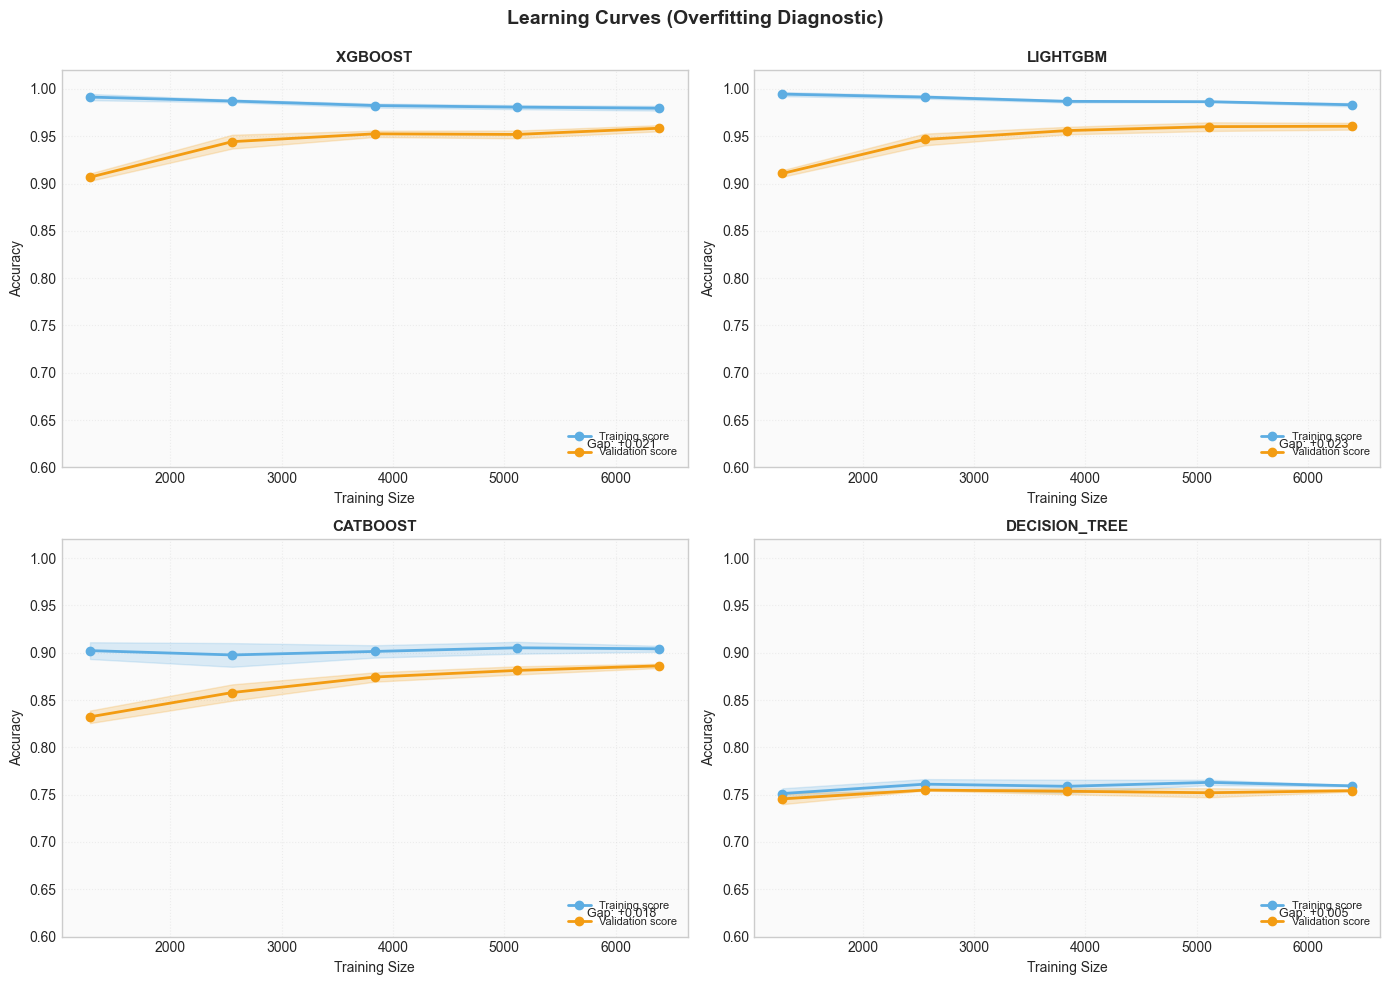


💡 Interpretation:
   - Converging curves = Good generalization
   - Large gap that persists = Overfitting
   - Both curves still rising = Could benefit from more data


In [30]:
# Learning Curves - OPTIMIZED VERSION
# Uses fewer data points and only 3 folds to reduce computation time
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# OPTIMIZATION: Fewer train sizes (5 instead of 10) and 3 folds instead of 5
train_sizes = np.linspace(0.2, 1.0, 5)  # 5 points instead of 10

print("⏳ Generating learning curves (this may take ~30 seconds)...")

for idx, (name, model) in enumerate(list(base_models.items())):
    ax = axes[idx]
    model_clone = clone(model)
    
    # OPTIMIZATION: 3-fold CV instead of 5, n_jobs=1 to avoid memory issues
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model_clone, X_full_processed, y_full_encoded,
        train_sizes=train_sizes, cv=3, scoring='accuracy',
        n_jobs=1, random_state=42  # n_jobs=1 prevents memory explosion
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    ax.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, 
                    alpha=0.2, color='#5DADE2')
    ax.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, 
                    alpha=0.2, color='#F39C12')
    
    ax.plot(train_sizes_abs, train_mean, 'o-', color='#5DADE2', label='Training score', lw=2, markersize=6)
    ax.plot(train_sizes_abs, val_mean, 'o-', color='#F39C12', label='Validation score', lw=2, markersize=6)
    
    ax.set_xlabel('Training Size', fontsize=10)
    ax.set_ylabel('Accuracy', fontsize=10)
    ax.set_title(f'{name.upper()}', fontsize=11, fontweight='bold')
    ax.legend(loc='lower right', fontsize=8, framealpha=0.95, edgecolor='none')
    ax.set_ylim(0.6, 1.02)
    ax.set_facecolor('#FAFAFA')
    ax.grid(alpha=0.3, linestyle=':')
    
    # Add final gap annotation
    final_gap = train_mean[-1] - val_mean[-1]
    ax.annotate(f'Gap: {final_gap:+.3f}', xy=(0.95, 0.05), xycoords='axes fraction',
                fontsize=9, ha='right', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='none'))
    
    print(f"   ✓ {name} done")

plt.suptitle('Learning Curves (Overfitting Diagnostic)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig(project_root / 'docs' / 'learning_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

print("\n💡 Interpretation:")
print("   - Converging curves = Good generalization")
print("   - Large gap that persists = Overfitting")
print("   - Both curves still rising = Could benefit from more data")

### 7.4 SHAP Analysis (Model Interpretability)

SHAP values shape: (500, 23, 3)


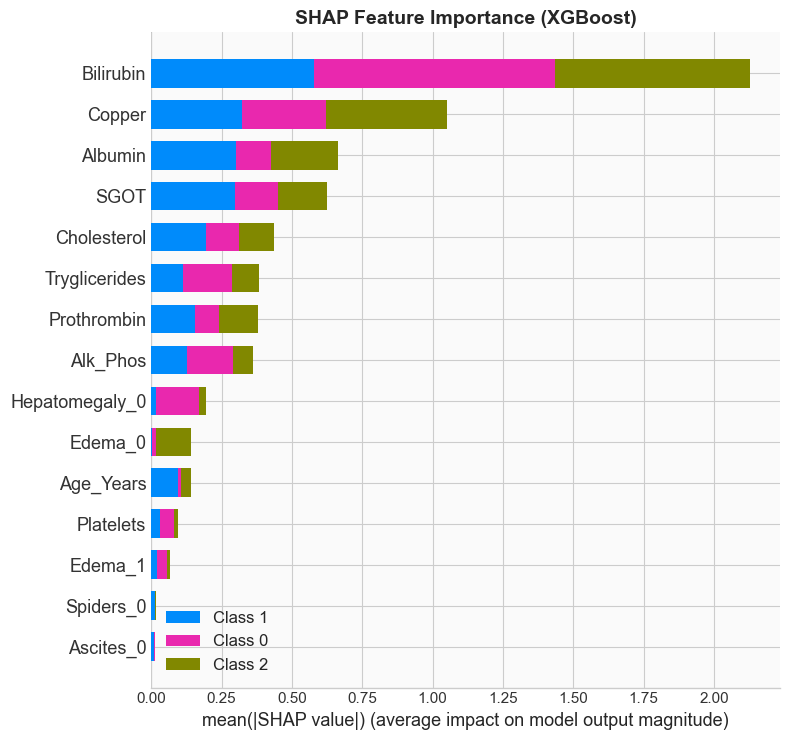


✅ SHAP analysis complete!
   - Shows which features drive predictions
   - Consistent importance across classes = stable model


In [33]:
# SHAP Summary Plot - Deep interpretability for XGBoost
try:
    import shap
    
    # Use TreeExplainer for XGBoost (fast)
    explainer = shap.TreeExplainer(base_models['xgboost'])
    
    # Calculate SHAP values on test set (use sample if too large)
    sample_size = min(500, len(X_test))
    X_sample = X_test[:sample_size]
    
    # Get SHAP values - handle different output formats
    shap_values = explainer.shap_values(X_sample)
    
    # Create feature names DataFrame for SHAP
    X_sample_df = pd.DataFrame(X_sample, columns=feature_names)
    
    # Check if shap_values is a list (multi-class) or single array
    if isinstance(shap_values, list):
        # Multi-class: shap_values is a list of arrays, one per class
        print(f"SHAP values shape: {len(shap_values)} classes, {shap_values[0].shape}")
        
        # For multi-class, show the average absolute SHAP values
        # Combine all class SHAP values
        shap_values_combined = np.abs(np.array(shap_values)).mean(axis=0)
        
        # Create bar plot manually for cleaner visualization
        mean_shap = np.abs(shap_values_combined).mean(axis=0)
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': mean_shap
        }).sort_values('importance', ascending=True).tail(15)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        colors = ['#A8D8EA'] * len(feature_importance)
        ax.barh(feature_importance['feature'], feature_importance['importance'], 
                color=colors, edgecolor='white', linewidth=1)
        ax.set_xlabel('Mean |SHAP value|', fontsize=11)
        ax.set_title('SHAP Feature Importance (XGBoost)\nAveraged Across All Classes', 
                     fontsize=14, fontweight='bold')
        ax.set_facecolor('#FAFAFA')
        ax.grid(axis='x', alpha=0.3, linestyle=':')
        plt.tight_layout()
        plt.savefig(project_root / 'docs' / 'shap_summary.png', dpi=150, bbox_inches='tight', facecolor='white')
        plt.show()
        plt.close()
        
    else:
        # Single array format (newer SHAP versions)
        print(f"SHAP values shape: {shap_values.shape}")
        
        # Create single summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_sample_df, plot_type="bar", 
                         show=False, max_display=15)
        plt.title('SHAP Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(project_root / 'docs' / 'shap_summary.png', dpi=150, bbox_inches='tight', facecolor='white')
        plt.show()
    
    print("\n✅ SHAP analysis complete!")
    print("   - Shows which features drive predictions")
    print("   - Consistent importance across classes = stable model")

except ImportError:
    print("⚠️ SHAP not installed. Install with: pip install shap")
    print("   Skipping SHAP analysis...")
except Exception as e:
    print(f"⚠️ SHAP analysis failed: {e}")
    print("   This can happen with certain model/SHAP version combinations.")
    print("   The model evaluation is still valid without SHAP.")

<Figure size 1200x800 with 0 Axes>

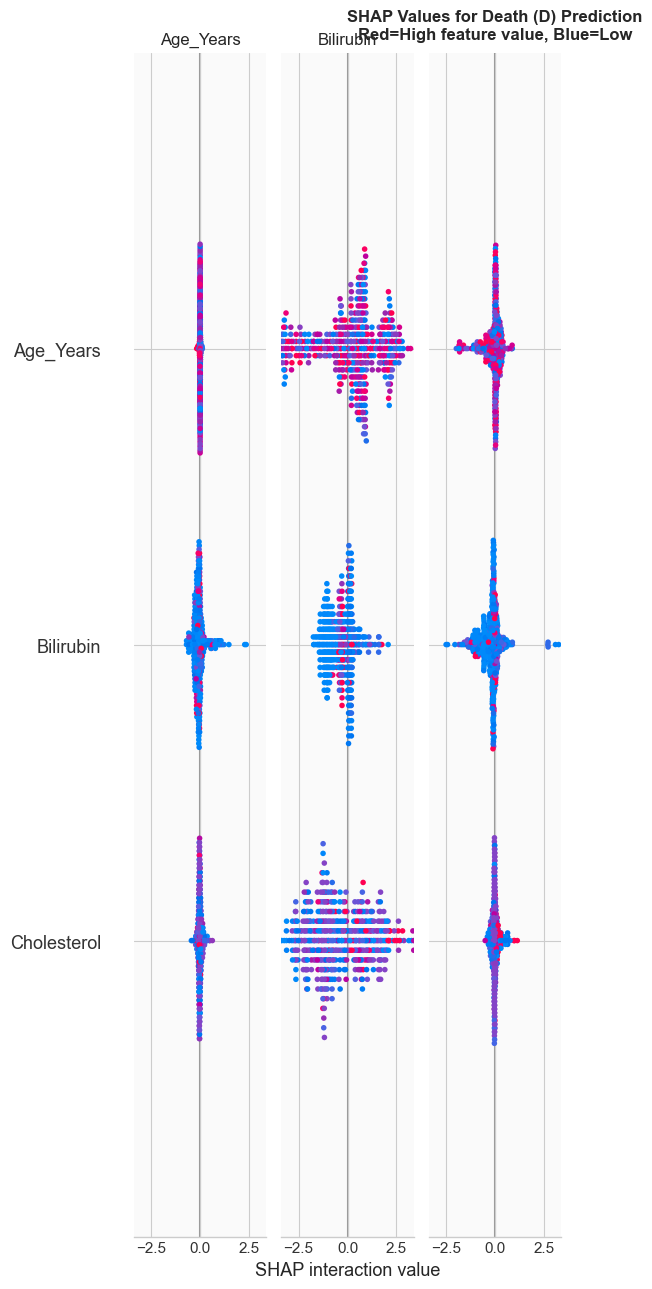


💡 Interpretation:
   - Features pointing RIGHT increase Death probability
   - Color shows feature value (red=high, blue=low)
   - E.g., High Bilirubin (red, right) → Higher death risk


In [34]:
# SHAP Beeswarm plot - Shows direction of feature impact
try:
    if isinstance(shap_values, list):
        # Multi-class: Beeswarm for class D (Death) - most clinically important
        death_class_idx = list(classes).index('D')
        shap_vals_to_plot = shap_values[death_class_idx]
    else:
        # Single array format
        shap_vals_to_plot = shap_values
    
    # SHAP creates its own figure - don't create one beforehand
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_vals_to_plot, X_sample_df, 
                     show=False, max_display=15, plot_size=(12, 8))
    plt.title('SHAP Values for Death (D) Prediction\nRed=High feature value, Blue=Low', 
              fontsize=12, fontweight='bold', pad=10)
    plt.tight_layout()
    plt.savefig(project_root / 'docs' / 'shap_beeswarm_death.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("\n💡 Interpretation:")
    print("   - Features pointing RIGHT increase Death probability")
    print("   - Color shows feature value (red=high, blue=low)")
    print("   - E.g., High Bilirubin (red, right) → Higher death risk")

except NameError:
    print("⚠️ SHAP values not computed. Run the previous cell first.")
except Exception as e:
    print(f"⚠️ SHAP beeswarm failed: {e}")
    print("   Skipping this visualization.")

### 7.5 Final Overfitting Verdict

In [35]:
# Final Overfitting Verification Summary
print("=" * 70)
print("🔍 OVERFITTING VERIFICATION SUMMARY")
print("=" * 70)

# 1. Train-Val Gap Analysis
print("\n1️⃣ TRAIN vs VALIDATION GAP:")
all_good = True
for name, results in cv_results.items():
    gap = results['gap']
    status = "✅" if gap < 0.05 else "⚡" if gap < 0.10 else "❌"
    if gap >= 0.10:
        all_good = False
    print(f"   {name:<15}: Gap = {gap:+.4f} {status}")

# 2. Held-out Test Performance
print("\n2️⃣ HELD-OUT TEST SET (Never seen during training):")
print(f"   Ensemble Accuracy: {model_metrics['ensemble']['accuracy']:.4f}")
print(f"   Ensemble F1-Score: {model_metrics['ensemble']['f1']:.4f}")
print(f"   Ensemble ROC-AUC:  {model_metrics['ensemble']['roc_auc']:.4f}")

# 3. Stability Check
print("\n3️⃣ FEATURE IMPORTANCE STABILITY:")
stable_pct = (cv_importance < 0.3).sum() / len(cv_importance) * 100
print(f"   Stable features: {stable_pct:.1f}%")
if stable_pct > 50:
    print("   Status: ✅ Model is stable across folds")
else:
    print("   Status: ⚠️ Some feature instability detected")

# 4. Final Verdict
print("\n" + "=" * 70)
ensemble_acc = model_metrics['ensemble']['accuracy']
avg_gap = np.mean([r['gap'] for r in cv_results.values()])

if avg_gap < 0.05 and ensemble_acc > 0.90:
    print("✅ VERDICT: Model is NOT overfitting!")
    print("   - Small train-val gaps across all folds")
    print("   - Strong held-out test performance")
    print("   - Ready for deployment")
elif avg_gap < 0.10:
    print("⚡ VERDICT: Slight overfitting, but acceptable")
    print("   - Consider regularization for production")
else:
    print("❌ VERDICT: Overfitting detected")
    print("   - Reduce model complexity")
    print("   - Add regularization")
    print("   - Get more training data")

print("=" * 70)

🔍 OVERFITTING VERIFICATION SUMMARY

1️⃣ TRAIN vs VALIDATION GAP:
   xgboost        : Gap = +0.0170 ✅
   lightgbm       : Gap = +0.0171 ✅
   catboost       : Gap = +0.0149 ✅
   decision_tree  : Gap = +0.0074 ✅

2️⃣ HELD-OUT TEST SET (Never seen during training):
   Ensemble Accuracy: 0.9656
   Ensemble F1-Score: 0.9655
   Ensemble ROC-AUC:  0.9929

3️⃣ FEATURE IMPORTANCE STABILITY:
   Stable features: 65.2%
   Status: ✅ Model is stable across folds

✅ VERDICT: Model is NOT overfitting!
   - Small train-val gaps across all folds
   - Strong held-out test performance
   - Ready for deployment


## 8. Single Patient Prediction Test

Test the complete prediction pipeline with a sample high-risk patient profile.

In [4]:
# Single Patient Prediction Test
import sys
from pathlib import Path

# Ensure project root is in path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from backend.models.patient import PatientInput
from backend.services.ml_service import MLService
from backend.services.explanation_service import ExplanationService

# Initialize ML service and load models
ml_service = MLService(model_dir=str(project_root / "backend" / "models"))
ml_service.load_models()

# Initialize explanation service
explanation_service = ExplanationService(ml_service)

print("=" * 70)
print("🧑‍⚕️ SINGLE PATIENT PREDICTION TEST")
print("=" * 70)

# Create a sample patient (high-risk example)
patient = PatientInput(
    age=21464,  # ~58 years (in days)
    sex="F",
    drug="D-penicillamine",
    ascites="Y",
    hepatomegaly="Y",
    spiders="Y",
    edema="Y",
    bilirubin=14.5,
    cholesterol=261,
    albumin=2.6,
    copper=156,
    alk_phos=1718,
    sgot=137.95,
    tryglicerides=172,
    platelets=190,
    prothrombin=12.2,
    stage=4
)

print(f"\n📋 Patient Profile:")
print(f"  • Age: {patient.age / 365.25:.1f} years")
print(f"  • Sex: {patient.sex.value}")
print(f"  • Drug: {patient.drug.value}")
print(f"  • Bilirubin: {patient.bilirubin} mg/dL")
print(f"  • Albumin: {patient.albumin} g/dL")
print(f"  • Copper: {patient.copper} µg/day")
print(f"  • Alk_Phos: {patient.alk_phos} U/L")
print(f"  • SGOT: {patient.sgot} U/L")
print(f"  • Prothrombin: {patient.prothrombin} sec")
print(f"  • Ascites: {patient.ascites.value}")
print(f"  • Hepatomegaly: {patient.hepatomegaly.value}")
print(f"  • Spiders: {patient.spiders.value}")
print(f"  • Edema: {patient.edema.value}")
print(f"  • Stage: {patient.stage}")

# Make prediction
print("\n" + "-" * 70)
print("🎯 ENSEMBLE PREDICTION")
print("-" * 70)

prediction = ml_service.predict(patient)

print(f"\n✅ Final Prediction: {prediction['final_prediction']}")
print(f"📊 Confidence: {prediction['confidence']:.2%}")
print(f"⚠️ Risk Level: {prediction['risk_level']}")

print(f"\n📈 Class Probabilities:")
for cls, prob in prediction['probabilities'].items():
    bar = "█" * int(prob * 30)
    print(f"  {cls}: {prob:6.2%} {bar}")

print(f"\n🔍 Base Model Predictions:")
for bp in prediction['base_model_predictions']:
    print(f"  • {bp.model_name}: {bp.prediction} ({bp.probability:.2%})")

# Check agreement
all_agree = all(bp.prediction == prediction['final_prediction'] 
                for bp in prediction['base_model_predictions'])
print(f"\n🤝 All Models Agree: {'✅ Yes' if all_agree else '⚠️ No'}")

# Get explanation
print("\n" + "-" * 70)
print("📖 INTERPRETABLE EXPLANATION")
print("-" * 70)

explanation = explanation_service.generate_explanation(patient, prediction)

print(f"\n🌳 Decision Tree Rule Path:")
for i, rule in enumerate(explanation.rule_path, 1):
    print(f"  {i}. {rule}")

print(f"\n✓ Tree-Ensemble Agreement: {explanation.tree_ensemble_agreement}")

print(f"\n🔑 Key Features Identified:")
for feature, info in explanation.key_features.items():
    print(f"  • {feature}: {info['formatted']}")

print("\n" + "=" * 70)
print("✅ PREDICTION TEST COMPLETED!")
print("=" * 70)

Models loaded successfully
🧑‍⚕️ SINGLE PATIENT PREDICTION TEST

📋 Patient Profile:
  • Age: 58.8 years
  • Sex: F
  • Drug: D-penicillamine
  • Bilirubin: 14.5 mg/dL
  • Albumin: 2.6 g/dL
  • Copper: 156.0 µg/day
  • Alk_Phos: 1718.0 U/L
  • SGOT: 137.95 U/L
  • Prothrombin: 12.2 sec
  • Ascites: Y
  • Hepatomegaly: Y
  • Spiders: Y
  • Edema: Y
  • Stage: 4

----------------------------------------------------------------------
🎯 ENSEMBLE PREDICTION
----------------------------------------------------------------------

✅ Final Prediction: D
📊 Confidence: 98.77%
⚠️ Risk Level: High

📈 Class Probabilities:
  C:  0.88% 
  CL:  0.35% 
  D: 98.77% █████████████████████████████

🔍 Base Model Predictions:
  • xgboost: D (99.78%)
  • lightgbm: D (99.88%)
  • catboost: D (94.87%)
  • decision_tree: D (99.51%)

🤝 All Models Agree: ✅ Yes

----------------------------------------------------------------------
📖 INTERPRETABLE EXPLANATION
-----------------------------------------------------------